In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"  
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dropout,  Input, Layer,Conv1DTranspose
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam


from pandas_datareader import data

from PyEMD import EMD,EEMD,CEEMDAN,Visualisation

In [78]:
import warnings
warnings.filterwarnings("ignore")

In [79]:
start = '2017-01-01'
end = '2019-01-01'
GSPC = pd.DataFrame(data.DataReader("^GSPC","yahoo",start,end)['Adj Close'])#Choose the data
print(GSPC)
GSPC.isnull().sum().sort_values(ascending = False)

              Adj Close
Date                   
2017-01-03  2257.830078
2017-01-04  2270.750000
2017-01-05  2269.000000
2017-01-06  2276.979980
2017-01-09  2268.899902
...                 ...
2018-12-24  2351.100098
2018-12-26  2467.699951
2018-12-27  2488.830078
2018-12-28  2485.739990
2018-12-31  2506.850098

[502 rows x 1 columns]


Adj Close    0
dtype: int64

In [80]:
def emd_calculate(data,emdtype=EMD, plots=True):
    EMD_C=emdtype()#EMD,EEMD,CEEMDAN
    imfs = EMD_C(data.values.reshape(len(data)))
        
    if plots:
        series_index = data.index
        fig = plt.figure(figsize=(16,2*len(imfs)))
        plt.subplot(1+len(imfs), 1, 1 )
        plt.plot(series_index, data, color='#0070C0') #F27F19 orange #0070C0 blue
        plt.ylabel('Original data')

        # Plot IMFs
        for i in range(len(imfs)):
            plt.subplot(1 +len(imfs),1,2 + i)
            plt.plot(series_index, imfs[i, :], color='#F27F19')
            plt.ylabel('IMF'+str(i))
        plt.show()
    imfs=pd.DataFrame(imfs,columns=data.index)
    return imfs

In [81]:
def create_noisy(data,percentage=0.5,size=10):
    data_noisy = pd.DataFrame()
    window=int(len(data) * percentage)
    for i in range(window,len(data),size):
        data_noisy= pd.concat([data_noisy,pd.Series(data.values[i-window:i,0])], axis=1)
    return data_noisy.T

In [82]:
def create_pure(data,percentage=0.5,size=10,emdtype=EMD,emdsum=1):
    data_pure = pd.DataFrame()
    window=int(len(data) * percentage)
    for i in range(window,len(data),size):
        temp=emd_calculate(data[i-window:i],plots=False,emdtype=emdtype)
        temp_1= reconstruction(temp)
        data_pure= pd.concat([data_pure,pd.Series(temp_1.values[emdsum,:])], axis=1)
    return data_pure.T

In [83]:
def reconstruction(data_emd):
    reconstruction = pd.DataFrame()
    for i in range(len(data_emd)):
        reconstruction['sum'+str(i)]=data_emd.iloc[i:,:].sum(axis=0)
    return reconstruction.T

In [175]:
GSPC_pure=create_pure(GSPC)

GSPC_noisy=create_noisy(GSPC)

In [176]:
mm_t_g = MinMaxScaler()
noise_mm = mm_t_g.fit_transform(GSPC_noisy.T).T
prue_mm=mm_t_g.fit_transform(GSPC_pure.T).T
print(prue_mm.shape)
print(noise_mm.shape)

(26, 251)
(26, 251)


In [177]:
X_train_mm = np.asarray(noise_mm)
X_train_mm=X_train_mm.reshape((len(X_train_mm), len(X_train_mm[0]), 1))
Y_train_mm = np.asarray(prue_mm)
Y_train_mm=Y_train_mm.reshape((len(Y_train_mm), len(Y_train_mm[0]), 1))
X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(X_train_mm, Y_train_mm, test_size=0.2,random_state=0,shuffle=False)

In [178]:
keras.backend.clear_session()

In [179]:
def set_model_encoding_mm():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same',input_shape=(None, 1)))
    model.add(Conv1D(64, kernel_size=3,activation='relu',padding='same'))
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(Conv1D(128, kernel_size=3,activation='relu',padding='same'))
    model.add(Conv1D(1,kernel_size=3,activation='sigmoid', padding='same'))
    model.compile(optimizer='adam' , loss='mse', metrics=['mae'])
    
    return model
modelen_mm = set_model_encoding_mm()
modelen_mm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         512       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          24640     
                                                                 
 conv1d_2 (Conv1D)           (None, None, 64)          12352     
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         24704     
                                                                 
 conv1d_4 (Conv1D)           (None, None, 1)           385       
                                                                 
Total params: 62,593
Trainable params: 62,593
Non-trainable params: 0
_________________________________________________________________


In [180]:
callback = EarlyStopping(monitor='loss', patience=10)
history_mm = modelen_mm.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=400, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/400
1/1 [==============================] - 0s 485ms/step - loss: 0.0729 - mae: 0.2299 - val_loss: 0.0643 - val_mae: 0.2123
Epoch 2/400
1/1 [==============================] - 0s 37ms/step - loss: 0.0707 - mae: 0.2261 - val_loss: 0.0618 - val_mae: 0.2082
Epoch 3/400
1/1 [==============================] - 0s 37ms/step - loss: 0.0687 - mae: 0.2228 - val_loss: 0.0592 - val_mae: 0.2039
Epoch 4/400
1/1 [==============================] - 0s 37ms/step - loss: 0.0667 - mae: 0.2191 - val_loss: 0.0564 - val_mae: 0.1990
Epoch 5/400
1/1 [==============================] - 0s 38ms/step - loss: 0.0645 - mae: 0.2149 - val_loss: 0.0538 - val_mae: 0.1941
Epoch 6/400
1/1 [==============================] - 0s 39ms/step - loss: 0.0622 - mae: 0.2105 - val_loss: 0.0512 - val_mae: 0.1891
Epoch 7/400
1/1 [==============================] - 0s 37ms/step - loss: 0.0598 - mae: 0.2055 - val_loss: 0.0487 - val_mae: 0.1842
Epoch 8/400
1/1 [==============================] - 0s 35ms/step - loss: 0.0571 - mae: 0.2

In [181]:
modelen_mm.save_weights('model_weights_mm.h5', overwrite=True)  

In [152]:
modelen_mm.load_weights('model_weights_mm.h5')

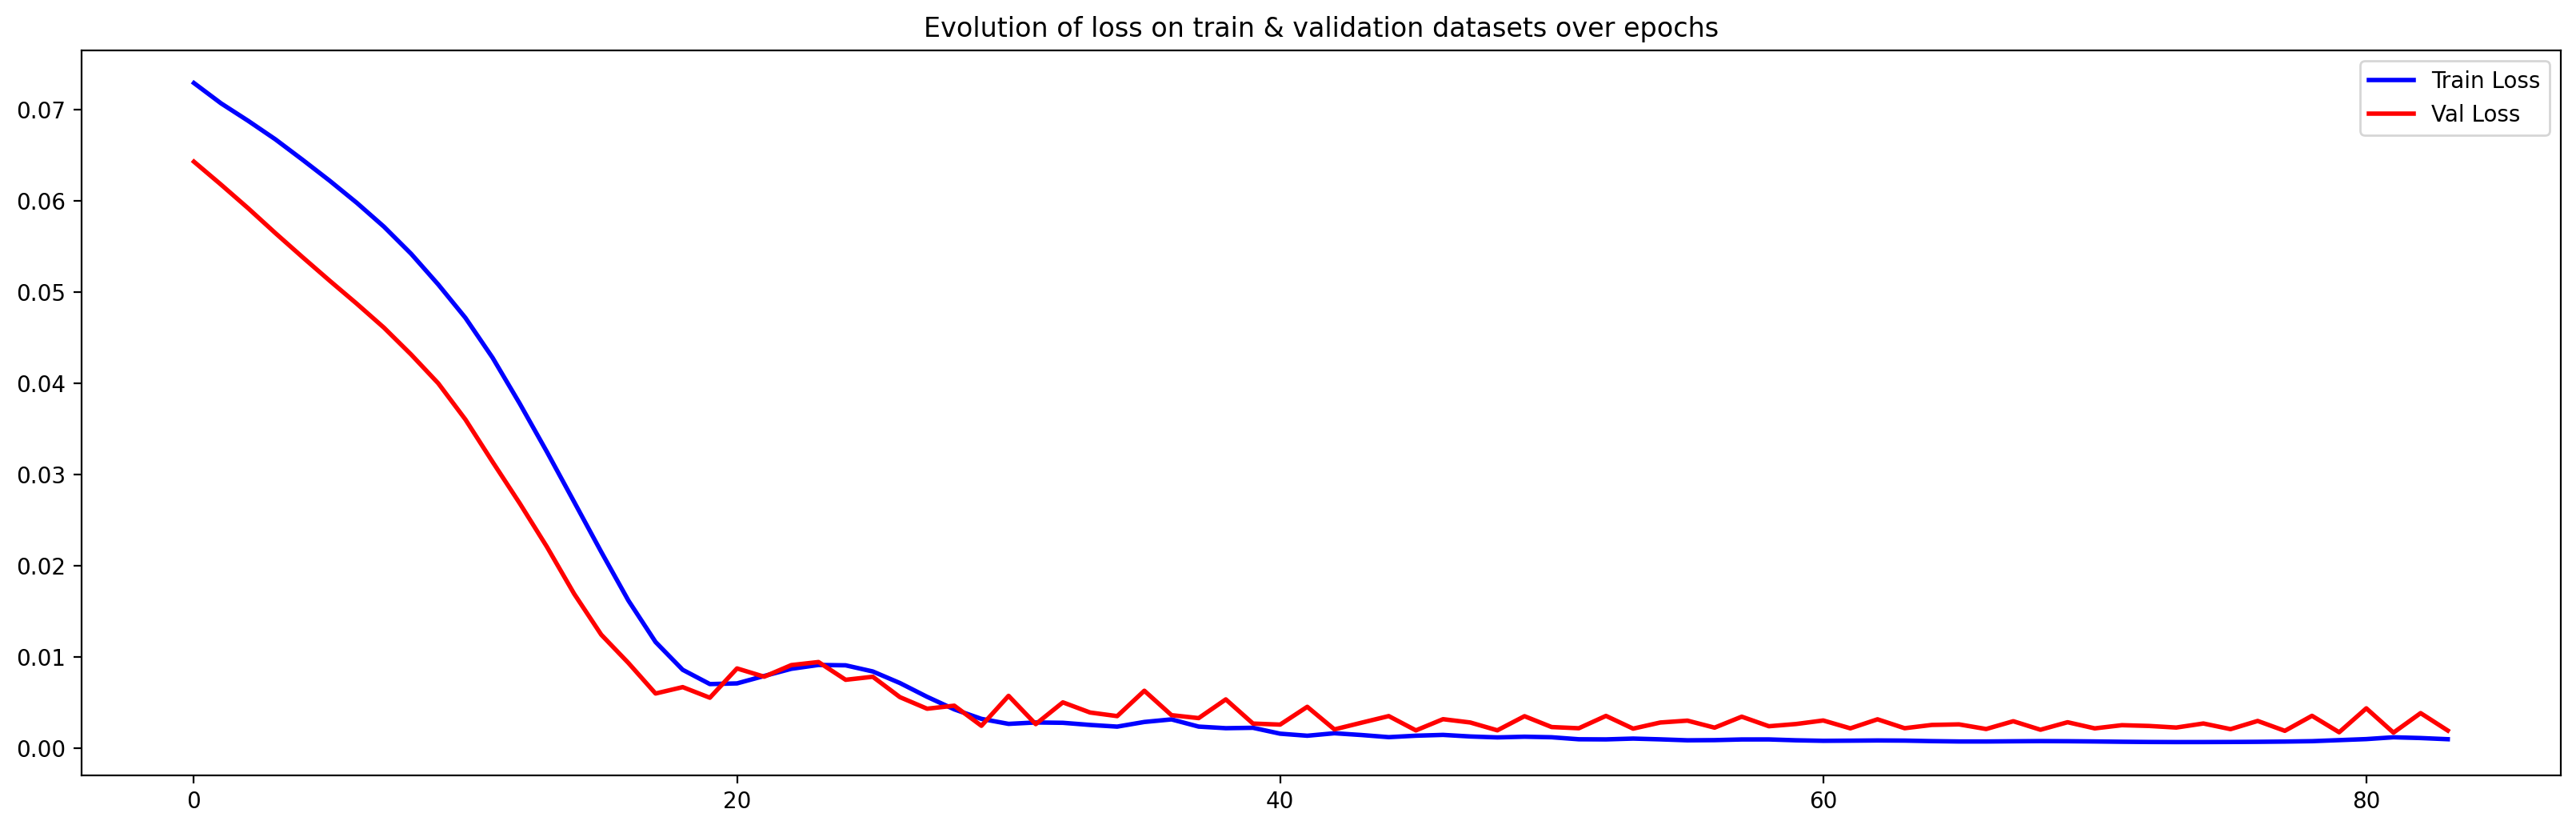

In [182]:
# Check how loss & mae went down
epoch_loss = history_mm.history['loss']
epoch_val_loss = history_mm.history['val_loss']

plt.figure(figsize=(20,6),dpi=200)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')


plt.show()

In [183]:
start = '2017-01-01'
end = '2019-01-01'
GSPC_test = pd.DataFrame(data.DataReader("^GSPC","yahoo",start,end)['Adj Close'])#Choose the data
GSPC_test

,Adj Close
Date,
2017-01-03,2257.830078
2017-01-04,2270.750000
2017-01-05,2269.000000
2017-01-06,2276.979980
2017-01-09,2268.899902
...,...
2018-12-24,2351.100098
2018-12-26,2467.699951
2018-12-27,2488.830078


1/1 [==============================] - 0s 61ms/step


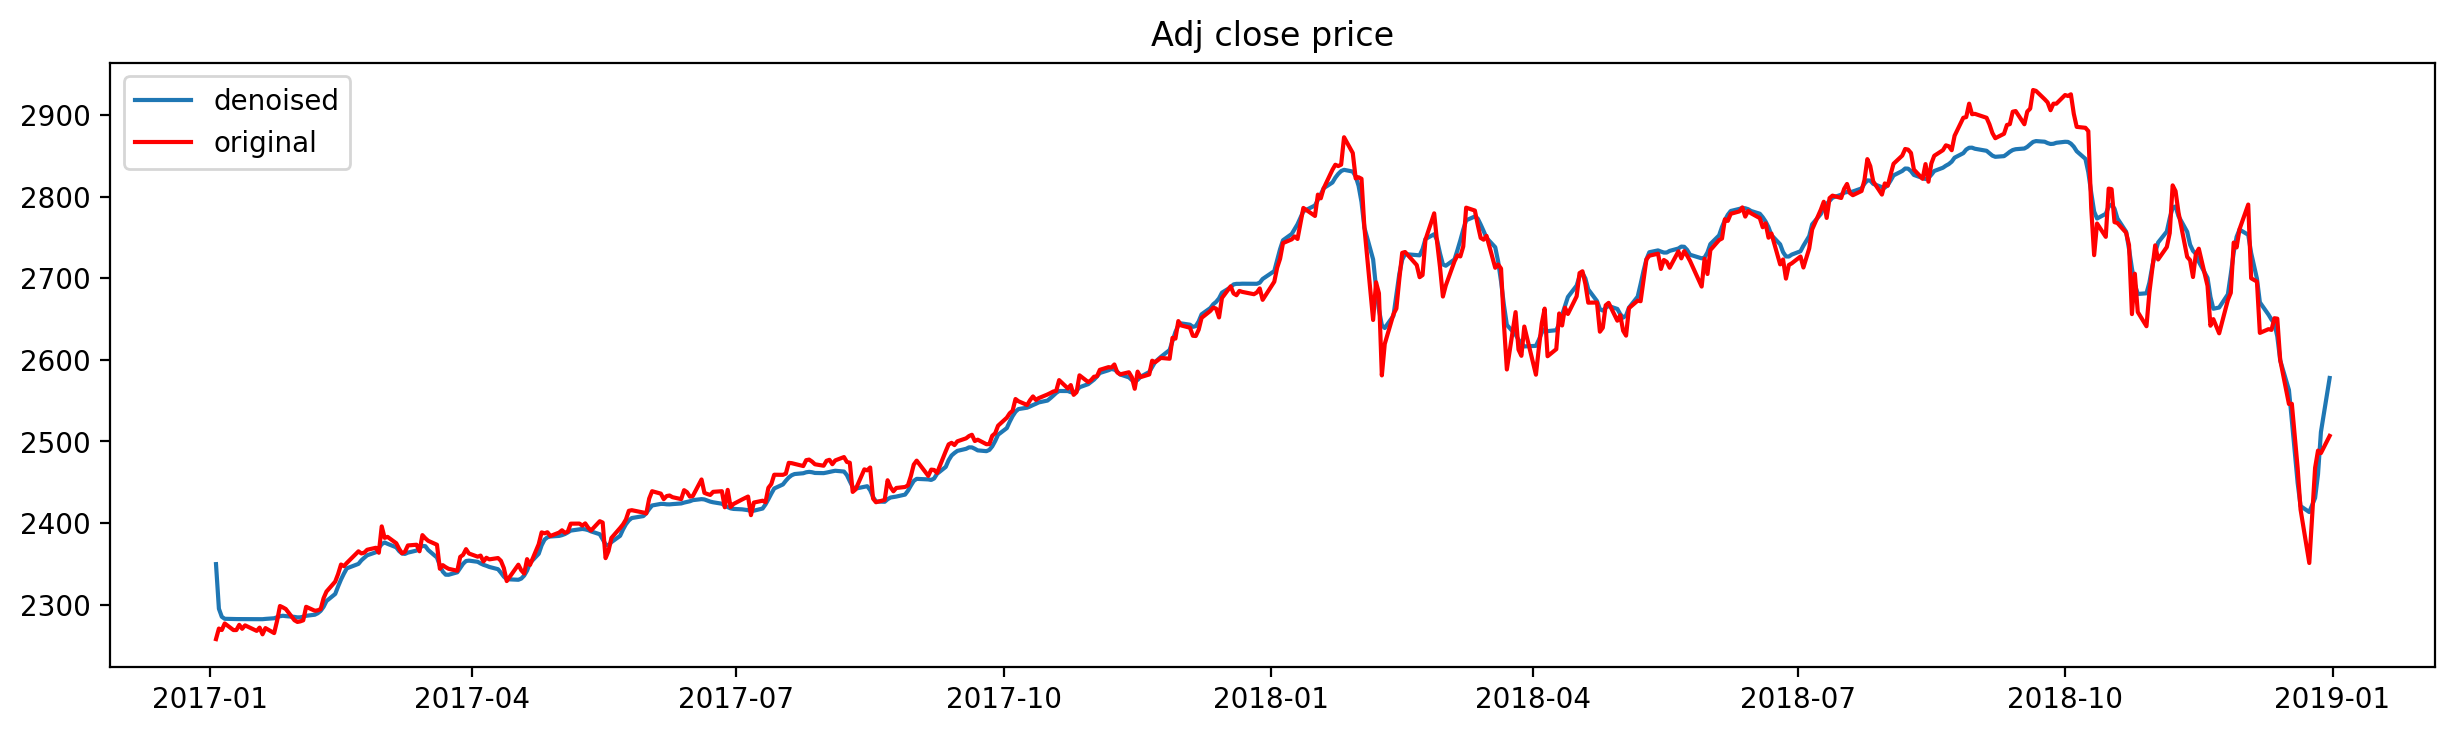

In [184]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_cnn = modelen_mm.predict(noise_mm_T.T)
Y_test_mm_cnn=Y_test_mm_cnn.reshape((len(GSPC_test),1))
pure_mm_cnn = mm_t.inverse_transform(Y_test_mm_cnn)
noise_mm_T=pd.DataFrame(noise_mm_T,columns=['Adj Close'],index=GSPC_test.index)
Y_test_mm_cnn=pd.DataFrame(Y_test_mm_cnn,columns=['Adj Close'],index=GSPC_test.index)
pure_mm_cnn=pd.DataFrame(pure_mm_cnn,columns=['Adj Close'],index=GSPC_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm_cnn)
plt.plot(GSPC_test,'r')
plt.title('Adj close price')
plt.legend(['denoised', 'original'], loc='upper left')

# regression

In [185]:
original=GSPC_test
recon=pure_mm_cnn

In [186]:
def features(dataset):
    ret_dataset=pd.DataFrame(index=dataset.index)
    for i in range(2,52,1):
        window = i
        # Volatility
        ret_dataset[str('SMA'+str(i))] = talib.SMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('EMA'+str(i))] = talib.EMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('STDDEV'+str(i))] = talib.STDDEV(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('Lag'+str(i))] = dataset['Adj Close'].shift(i)
    return ret_dataset

In [187]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import talib
splits=10

1844.3640331335184
2218.5896013786155
6935.061678229309
5586.876736267311
4228.317855695399
1125.5817425091093
531.5193698246304
2261.066335503648
1764.3861789325388
2690.7148246329007
The last MSE: 2690.7148246329007
The average MSE: 2918.647835610698


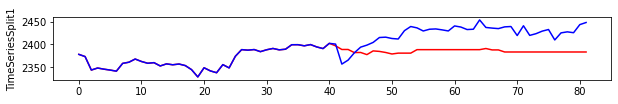

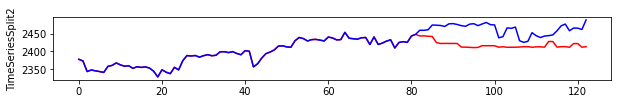

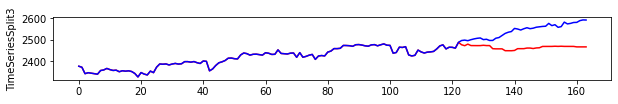

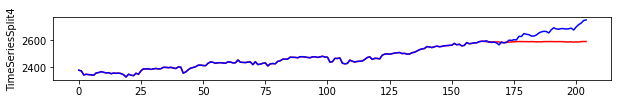

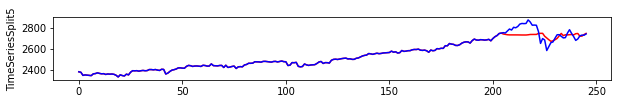

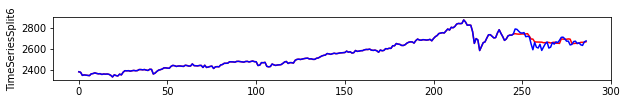

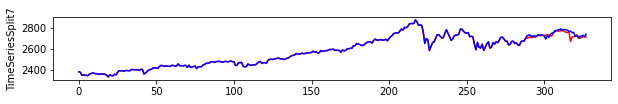

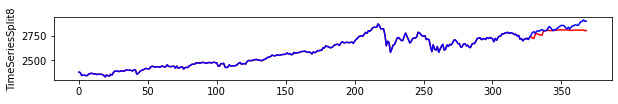

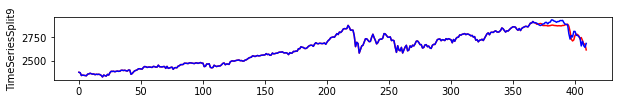

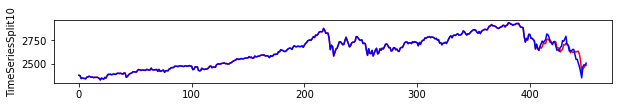

In [188]:
recon_fea=features(recon)
recon_fea=recon_fea.iloc[51:]
original_m=original.iloc[51::]
recon_m=recon.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0

for train_index, test_index in tscv.split(recon_fea):
    model = xgb.XGBRegressor()
    model.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(recon_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    print(msetest)
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

In [23]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV 
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import HalvingGridSearchCV
parameters = {  'max_depth': [1, 2, 3, 5, 10],
    'learning_rate': [ 0.02, 0.05, 0.1, 0.15],
  'n_estimators': [ 200, 300, 500, 700]}  # Specify the range of hyperparameters in the model to reduce time spent

In [24]:
# In the following we pass the data into the grid search model and output the hyperparameter optimal values.
reg = xgb.XGBRegressor(eval_metric=mean_squared_error)  # Building the model
grid_search = HalvingGridSearchCV(reg, parameters, scoring='neg_mean_squared_error',verbose=1,cv=None) 
grid_search.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])  # Input data
print("Optimal values for hyperparameters:",grid_search.best_params_)
print("Best model score:",grid_search.best_score_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 15
max_resources_: 410
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 80
n_resources: 15
Fitting 5 folds for each of 80 candidates, totalling 400 fits
----------
iter: 1
n_candidates: 27
n_resources: 45
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 2
n_candidates: 9
n_resources: 135
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 3
n_candidates: 3
n_resources: 405
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Optimal values for hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
Best model score: -2658.7573462740875


In [25]:
model = xgb.XGBRegressor(
                        n_estimators=500,
                        max_depth=5,
                        learning_rate=0.1,)
model.fit (recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
test_predict=model.predict(recon_fea.iloc[test_index,:])
msetest=mean_squared_error(recon_m.iloc[test_index,:],test_predict)
msetest

2202.044

In [26]:
parameters = {  'max_depth':[1, 2, 3, 5, 10],
    'learning_rate': [ 0.02, 0.05, 0.1, 0.15],
    'n_estimators': [ 100,200, 300, 500, 700],
    'min_child_weight': [0, 2, 5, 10, 20],
    #'max_delta_step': [0, 0.2, 0.6, 1, 2],
    'subsample': [0.6, 0.7, 0.8, 0.85, 0.95],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
    'reg_lambda': [0.2, 0.4, 0.6, 0.8, 1],
    'scale_pos_weight': [0.2, 0.4, 0.6, 0.8, 1],
    'gamma':[0,0.01,0.05,0.1,0.2,0.4,0.6]}  # Specify the range of hyperparameters in the model to reduce time spent

In [27]:
regran = xgb.XGBRegressor(eval_metric=mean_squared_error)  
Rgrid_search = HalvingRandomSearchCV(regran, parameters, scoring='neg_mean_squared_error', verbose=1,cv=None) 
Rgrid_search.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:]) 
print("Optimal values for hyperparameters:",Rgrid_search.best_params_)
print("Best model score:",Rgrid_search.best_score_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 10
max_resources_: 410
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 41
n_resources: 10
Fitting 5 folds for each of 41 candidates, totalling 205 fits
----------
iter: 1
n_candidates: 14
n_resources: 30
Fitting 5 folds for each of 14 candidates, totalling 70 fits
----------
iter: 2
n_candidates: 5
n_resources: 90
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 3
n_candidates: 2
n_resources: 270
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Optimal values for hyperparameters: {'subsample': 0.85, 'scale_pos_weight': 0.8, 'reg_lambda': 0.2, 'reg_alpha': 0, 'n_estimators': 700, 'min_child_weight': 0, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.9}
Best model score: -2155.955353245691


In [28]:
model = xgb.XGBRegressor(subsample=0.85,
                        scale_pos_weight=0.8,
                        reg_lambda=0.2,
                        reg_alpha=0,
                        n_estimators=700,
                        min_child_weight=0,
                        max_depth=5,
                        #max_delta_step=0,
                        learning_rate=0.05,
                        gamma=0.4,
                        colsample_bytree=0.9)
model.fit (recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
test_predict=model.predict(recon_fea.iloc[test_index,:])
msetest=mean_squared_error(recon_m.iloc[test_index,:],test_predict)
msetest

1775.161

In [189]:
from bayes_opt import BayesianOptimization
def rf_do(max_depth, learning_rate, n_estimators, min_child_weight, subsample, colsample_bytree,reg_alpha,reg_lambda,scale_pos_weight,gamma):
    val = xgb.XGBRegressor(max_depth = round(max_depth),
                           learning_rate = float(learning_rate),
                           n_estimators = round(n_estimators),
                           min_child_weight = round(min_child_weight),
                           #max_delta_step = float(max_delta_step),
                           subsample = float(subsample),
                           colsample_bytree = float(colsample_bytree),
                           reg_alpha = float(reg_alpha),
                           reg_lambda = float(reg_lambda),
                           scale_pos_weight = float(scale_pos_weight),
                           gamma = float(gamma),
                           eval_metric=mean_squared_error)
    msetest=0
    val.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=val.predict(recon_fea.iloc[test_index,:])
    msetest=-1*mean_squared_error(recon_m.iloc[test_index,:],test_predict)
    return msetest

In [190]:
rf_bo = BayesianOptimization(
        rf_do,
                {'max_depth':(1,20),
                'learning_rate': (0.01,0.3),
                'n_estimators': (100,1000),
                'min_child_weight': (0,2),
                #'max_delta_step': (0.01,1),
                'subsample':(0.5,1),
                'colsample_bytree': (0.5,1),
                'reg_alpha': (0.01,1),
                'reg_lambda': (0.2,1),
                'scale_pos_weight': (0.2,1),
                'gamma':(0,1)}
    )
rf_bo.maximize()#init_points=20, n_iter=10
rf_bo_p=rf_bo.max
rf_bo_p['params']['max_depth'] = round(rf_bo_p['params']['max_depth'])
rf_bo_p['params']['n_estimators'] = round(rf_bo_p['params']['n_estimators'])
rf_bo_p['params']['min_child_weight'] = round(rf_bo_p['params']['min_child_weight'])
rf_bo_p

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -2.066e+0 |  0.9475   |  0.1884   |  0.1599   |  5.21     |  0.5741   |  511.1    |  0.9654   |  0.9912   |  0.9577   |  0.848    |
|  2        | -1.55e+03 |  0.6529   |  0.5386   |  0.03952  |  16.33    |  0.683    |  317.0    |  0.2243   |  0.4347   |  0.7193   |  0.6831   |
|  3        | -2.424e+0 |  0.7324   |  0.1383   |  0.1329   |  17.94    |  1.388    |  139.4    |  0.2515   |  0.9465   |  0.2856   |  0.8067   |
|  4        | -1.64e+03 |  0.677    |  0.8959   |  0.1042   |  17.35    |  1.355    |  691.9    |  0.3115   |  0.9246   |  0.7752   |  0.5147   |
|  5        | -2.141e+0 |  0.7942   |  0.8935   |  0.1591   |  9.35     |  1.723    |  316.4    |  0.1989   |  0.3866   |  0

{'target': -1387.8521728515625,
 'params': {'colsample_bytree': 0.8529445780872431,
  'gamma': 0.909873983445018,
  'learning_rate': 0.17092846148088656,
  'max_depth': 15,
  'min_child_weight': 1,
  'n_estimators': 690,
  'reg_alpha': 0.8182976049188978,
  'reg_lambda': 0.7032664754582003,
  'scale_pos_weight': 0.9729136876771614,
  'subsample': 0.7042767367239444}}

The last MSE: 4746.077826718005
The average MSE: 3393.831031094819


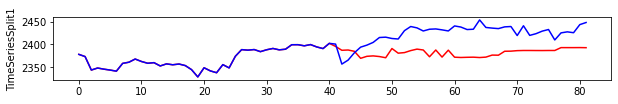

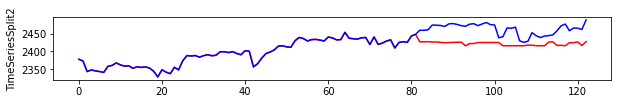

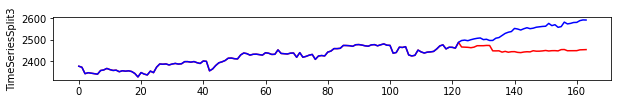

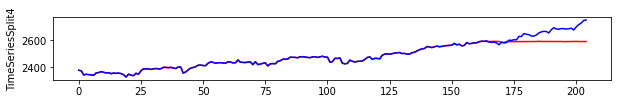

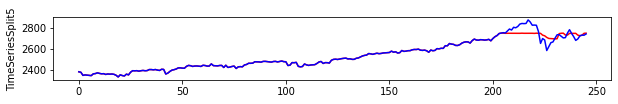

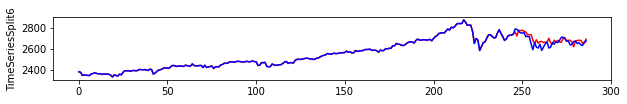

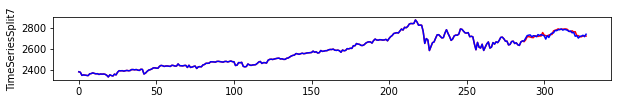

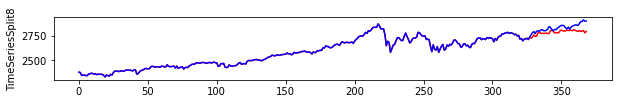

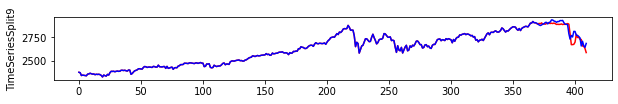

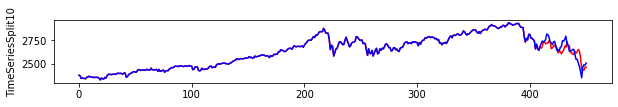

In [51]:
original_fea=features(original)
original_fea=original_fea.iloc[51:]
original_m=original.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(original_fea):
    model = xgb.XGBRegressor()
    model.fit (original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(original_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

In [128]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV 
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import HalvingGridSearchCV
parameters = {  'max_depth': [1, 2, 3, 5, 10],
    'learning_rate': [ 0.02, 0.05, 0.1, 0.15],
  'n_estimators': [ 200, 300, 500, 700]}  # Specify the range of hyperparameters in the model to reduce time spent

In [129]:
# In the following we pass the data into the grid search model and output the hyperparameter optimal values.
reg = xgb.XGBRegressor(eval_metric=mean_squared_error)  # Building the model
grid_search = HalvingGridSearchCV(reg, parameters, scoring='neg_mean_squared_error',verbose=1,cv=None) 
grid_search.fit(original_fea.iloc[train_index,:],original_m.iloc[train_index,:])  # Input data
print("Optimal values for hyperparameters:",grid_search.best_params_)
print("Best model score:",grid_search.best_score_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 15
max_resources_: 410
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 80
n_resources: 15
Fitting 5 folds for each of 80 candidates, totalling 400 fits
----------
iter: 1
n_candidates: 27
n_resources: 45
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 2
n_candidates: 9
n_resources: 135
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 3
n_candidates: 3
n_resources: 405
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Optimal values for hyperparameters: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 700}
Best model score: -2811.671274117187


In [130]:
model = xgb.XGBRegressor(
                        n_estimators=700,
                        max_depth=10,
                        learning_rate=0.05,)
model.fit (original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
test_predict=model.predict(original_fea.iloc[test_index,:])
msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
msetest

4087.8457103080864

In [131]:
parameters = {  'max_depth':[1, 2, 3, 5, 10],
    'learning_rate': [ 0.02, 0.05, 0.1, 0.15],
    'n_estimators': [ 100,200, 300, 500, 700],
    'min_child_weight': [0, 2, 5, 10, 20],
    'subsample': [0.6, 0.7, 0.8, 0.85, 0.95],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
    'reg_lambda': [0.2, 0.4, 0.6, 0.8, 1],
    'scale_pos_weight': [0.2, 0.4, 0.6, 0.8, 1],
    'gamma':[0,0.01,0.05,0.1,0.2,0.4,0.6]}  # Specify the range of hyperparameters in the model to reduce time spent

In [132]:
regran = xgb.XGBRegressor(eval_metric=mean_squared_error)  
Rgrid_search = HalvingRandomSearchCV(regran, parameters, scoring='neg_mean_squared_error', verbose=1,cv=None) 
Rgrid_search.fit(original_fea.iloc[train_index,:],original_m.iloc[train_index,:]) 
print("Optimal values for hyperparameters:",Rgrid_search.best_params_)
print("Best model score:",Rgrid_search.best_score_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 10
max_resources_: 410
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 41
n_resources: 10
Fitting 5 folds for each of 41 candidates, totalling 205 fits
----------
iter: 1
n_candidates: 14
n_resources: 30
Fitting 5 folds for each of 14 candidates, totalling 70 fits
----------
iter: 2
n_candidates: 5
n_resources: 90
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 3
n_candidates: 2
n_resources: 270
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Optimal values for hyperparameters: {'subsample': 0.85, 'scale_pos_weight': 1, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 100, 'min_child_weight': 0, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best model score: -2465.0599124113714


In [133]:
model = xgb.XGBRegressor(subsample=0.85,
                        scale_pos_weight=1,
                        reg_lambda=1,
                        reg_alpha=0.5,
                        n_estimators=100,
                        min_child_weight=0,
                        max_depth=10,
                        learning_rate=0.1,
                        gamma=0.1,
                        colsample_bytree=0.7)
model.fit (original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
test_predict=model.predict(original_fea.iloc[test_index,:])
msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
msetest

5002.151511272279

In [134]:
def rf_oo(max_depth, learning_rate, n_estimators, min_child_weight, subsample, colsample_bytree,reg_alpha,reg_lambda,scale_pos_weight,gamma):
    val = xgb.XGBRegressor(max_depth = round(max_depth),
                           learning_rate = float(learning_rate),
                           n_estimators = round(n_estimators),
                           min_child_weight = round(min_child_weight),
                           subsample = float(subsample),
                           colsample_bytree = float(colsample_bytree),
                           reg_alpha = float(reg_alpha),
                           reg_lambda = float(reg_lambda),
                           scale_pos_weight = float(scale_pos_weight),
                           gamma = float(gamma),
                           eval_metric=mean_squared_error)
    msetest=0
    val.fit(original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=val.predict(original_fea.iloc[test_index,:])
    msetest=-1*mean_squared_error(original_m.iloc[test_index,:],test_predict)
    return msetest

In [136]:
rf_bo = BayesianOptimization(
        rf_oo,
                {'max_depth':(1,20),
                'learning_rate': (0.01,0.3),
                'n_estimators': (100,1000),
                'min_child_weight': (0,2),
                'subsample':(0.5,1),
                'colsample_bytree': (0.5,1),
                'reg_alpha': (0.01,1),
                'reg_lambda': (0.2,1),
                'scale_pos_weight': (0.2,1),
                'gamma':(0,1)}
    )
rf_bo.maximize()#init_points=20, n_iter=10
rf_bo_p=rf_bo.max
rf_bo_p['params']['max_depth'] = round(rf_bo_p['params']['max_depth'])
rf_bo_p['params']['n_estimators'] = round(rf_bo_p['params']['n_estimators'])
rf_bo_p['params']['min_child_weight'] = round(rf_bo_p['params']['min_child_weight'])
rf_bo_p

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -5.035e+0 |  0.9576   |  0.6942   |  0.1761   |  2.358    |  1.468    |  863.8    |  0.8193   |  0.236    |  0.3798   |  0.5185   |
|  2        | -3.064e+0 |  0.831    |  0.5045   |  0.2843   |  6.179    |  0.5314   |  547.6    |  0.09154  |  0.6633   |  0.4189   |  0.6231   |
|  3        | -5.07e+03 |  0.6936   |  0.9458   |  0.2473   |  2.842    |  1.85     |  119.4    |  0.0134   |  0.63     |  0.4476   |  0.9419   |
|  4        | -4.822e+0 |  0.6018   |  0.8073   |  0.05011  |  3.837    |  0.6315   |  182.8    |  0.9972   |  0.7025   |  0.6522   |  0.9641   |
|  5        | -3.969e+0 |  0.633    |  0.8344   |  0.1173   |  18.49    |  1.098    |  160.4    |  0.2405   |  0.9852   |  0

{'target': -2740.978656614699,
 'params': {'colsample_bytree': 0.8801942887428402,
  'gamma': 0.4949136725489275,
  'learning_rate': 0.19540909776591325,
  'max_depth': 13,
  'min_child_weight': 2,
  'n_estimators': 307,
  'reg_alpha': 0.07304435288216779,
  'reg_lambda': 0.5610165969052465,
  'scale_pos_weight': 0.991528471214048,
  'subsample': 0.6876691993702213}}

# EMDCNN

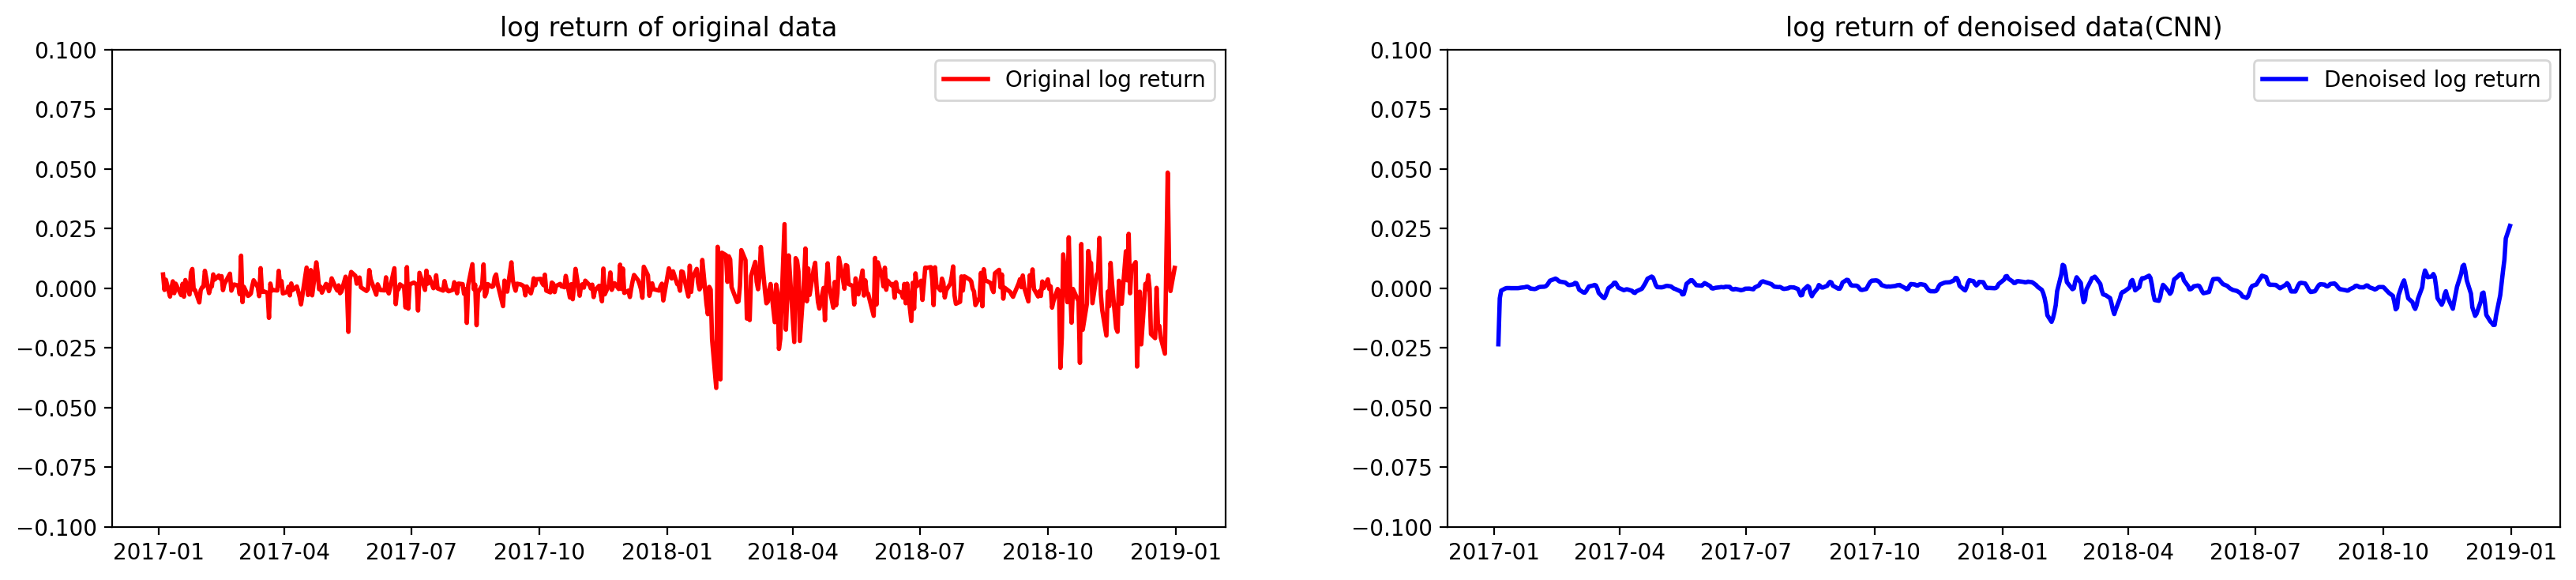

In [191]:
# Log Returns
GSPC_test_n=GSPC_test.copy()
GSPC_test_n['log_ret'] = np.log(GSPC_test.iloc[:,0]).diff()
pure_mm_cnn['log_ret'] = np.log(pure_mm_cnn.iloc[:,0]).diff()


plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,2,1)
plt.plot(GSPC_test_n['log_ret'], 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.1,0.1)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(pure_mm_cnn['log_ret'] , 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.1,0.1)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')


plt.show()

In [192]:
def svmf1_ori(dataset,dataset2,long_predict=10,percentage=0.8):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/100):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/100):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [193]:
original_svm_ori,denoised_svm_ori=svmf1_ori(GSPC_test_n,pure_mm_cnn,long_predict=1,percentage=1)

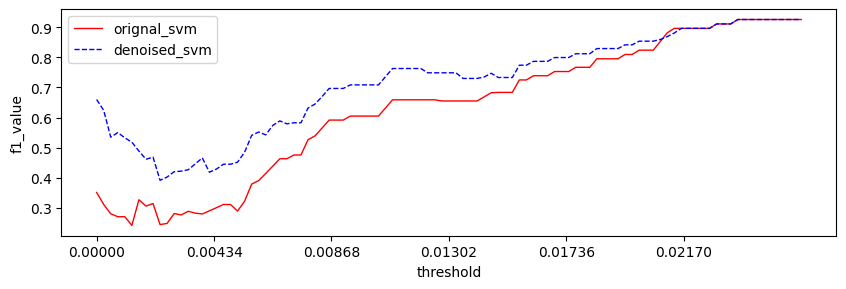

In [194]:
plt.figure(figsize=(10,3),dpi=100)
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/100),original_svm_ori,label='orignal_svm', color='red', linewidth=1.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/100),denoised_svm_ori,label='denoised_svm', color='blue', linewidth=1.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

## Strategies 

## Bollinger band

In [35]:
def bbands(close_prices, window, no_of_stdev):#bollinger  bands, using today's closing price

    rolling_mean = close_prices.rolling(window,min_periods=1).mean()#.shift(1)
    rolling_std = close_prices.rolling(window,min_periods=1).std()#.shift(1)
    

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [36]:
def buy_signal_function(dataset):
    buy_signal=pd.DataFrame(columns=['Price'],index=dataset.index)
    buy_signal['Price']=dataset['Adj Close']
    buy_signal['mean'],buy_signal['upper'],buy_signal['lower']=bbands(dataset['Adj Close'],20,2)
    buy_signal['side'] = np.nan 
    buy_signal['signal'] = np.nan 
    for i in range(0,len(dataset)):
        if (buy_signal.iloc[i,0]<buy_signal.iloc[i,3]):
            buy_signal.iloc[i,4]=1
            if (buy_signal.iloc[i-1,0]>=buy_signal.iloc[i-1,3]):
                buy_signal.iloc[i,5]=1
        elif (buy_signal.iloc[i,0]>buy_signal.iloc[i,2]):
            buy_signal.iloc[i,4]=-1
            if (buy_signal.iloc[i-1,0]<=buy_signal.iloc[i-1,2]):
                buy_signal.iloc[i,5]=-1
    return buy_signal

In [37]:
GSPC_test_signal=buy_signal_function(GSPC_test_n)


pure_mm_cnn_signal=buy_signal_function(pure_mm_cnn)


In [38]:

print('GSPC_test_signal:\n',GSPC_test_signal.signal.value_counts(),'\n')
print('pure_mm_cnn_signal:\n',pure_mm_cnn_signal.signal.value_counts(),'\n')


GSPC_test_signal:
 -1.0    17
 1.0    14
Name: signal, dtype: int64 

pure_mm_cnn_signal:
 -1.0    13
 1.0     9
Name: signal, dtype: int64 



In [39]:
print(GSPC_test[GSPC_test_signal.signal == 1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == 1.0])

              Adj Close
Date                   
2017-03-21  2344.020020
2017-04-13  2328.949951
2017-06-29  2419.699951
2017-07-06  2409.750000
2017-08-10  2438.209961
2017-08-17  2430.010010
2018-02-05  2648.939941
2018-02-08  2581.000000
2018-03-22  2643.689941
2018-06-27  2699.629883
2018-10-10  2785.679932
2018-10-24  2656.100098
2018-12-17  2545.939941
2018-12-19  2506.959961
              Adj Close
Date                   
2017-03-21  2344.020020
2017-06-29  2419.699951
2017-08-10  2438.209961
2017-08-17  2430.010010
2018-02-05  2648.939941
2018-03-22  2643.689941
2018-10-08  2884.429932
2018-10-24  2656.100098
2018-12-17  2545.939941


In [40]:
print(GSPC_test[GSPC_test_signal.signal == -1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == -1.0])

              Adj Close
Date                   
2017-01-25  2298.370117
2017-02-10  2316.100098
2017-02-21  2365.379883
2017-04-25  2388.610107
2017-06-02  2439.070068
2017-07-14  2459.270020
2017-07-19  2473.830078
2017-09-12  2496.479980
2017-10-05  2552.070068
2017-10-27  2581.070068
2017-11-28  2627.040039
2018-01-04  2723.989990
2018-01-12  2786.239990
2018-05-10  2723.070068
2018-06-06  2772.350098
2018-08-27  2896.739990
2018-09-20  2930.750000
              Adj Close
Date                   
2017-02-07  2293.080078
2017-04-24  2374.149902
2017-05-24  2404.389893
2017-06-01  2430.060059
2017-07-13  2447.830078
2017-09-11  2488.110107
2017-10-03  2534.580078
2017-11-22  2597.080078
2018-01-04  2723.989990
2018-05-10  2723.070068
2018-06-05  2748.800049
2018-08-07  2858.449951
2018-08-27  2896.739990


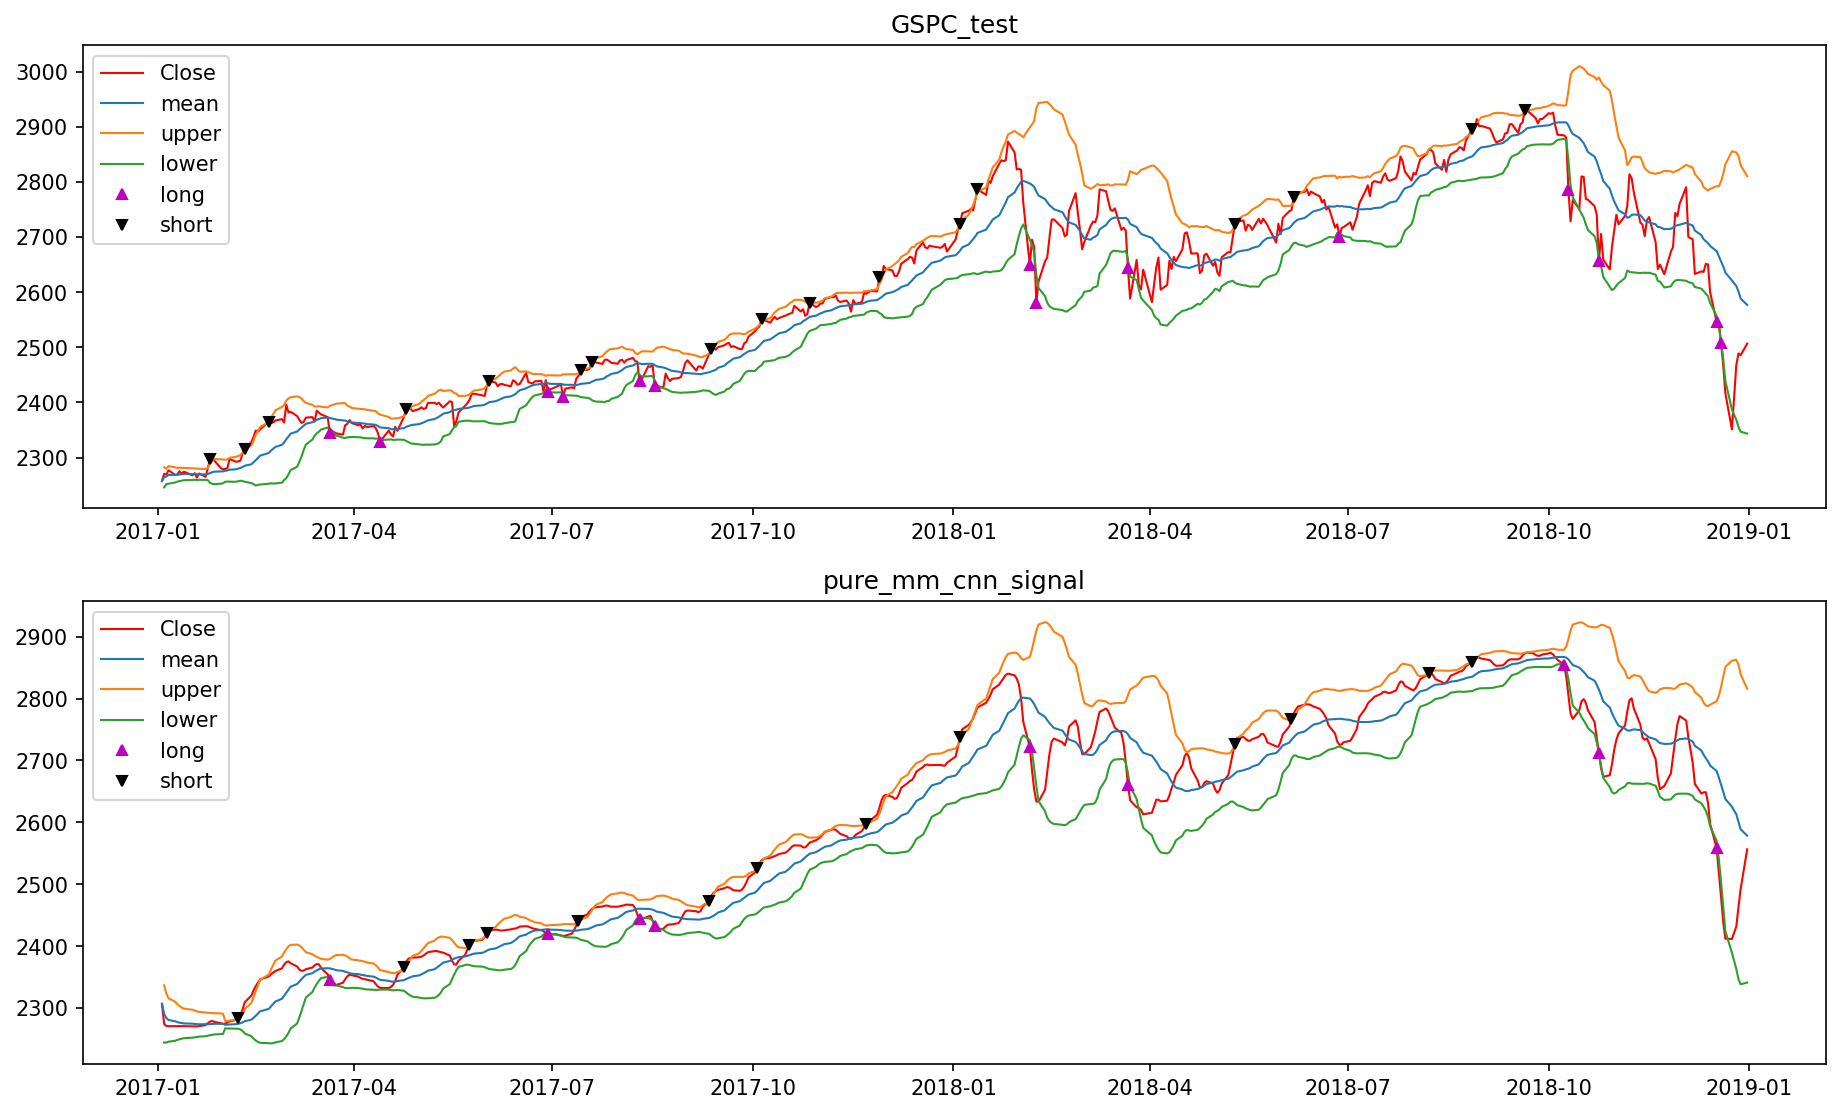

In [41]:
plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_signal['Price'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == 1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == -1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn_signal')
plt.plot(pure_mm_cnn_signal['Price'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == 1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == -1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()    


## MACD

In [42]:
def MACD(dataset,short_window = 12,long_window = 26, signal_window=9):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term moving averages
    signals['short_mavg'] = dataset['Adj Close'].ewm(span=short_window, min_periods=1).mean()

    # Calculate long term moving averages
    signals['long_mavg'] = dataset['Adj Close'].ewm(span=long_window, min_periods=1).mean()
    
    # Calculate DIF 
    signals['DIF'] = signals['short_mavg']-signals['long_mavg']
    
     # Calculate DIF moving averages
    signals['DEA'] = signals['DIF'].ewm(span=signal_window, min_periods=1).mean()

    # Generate signal
    signals['signal'] = np.where(signals['DIF']> signals['DEA'], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

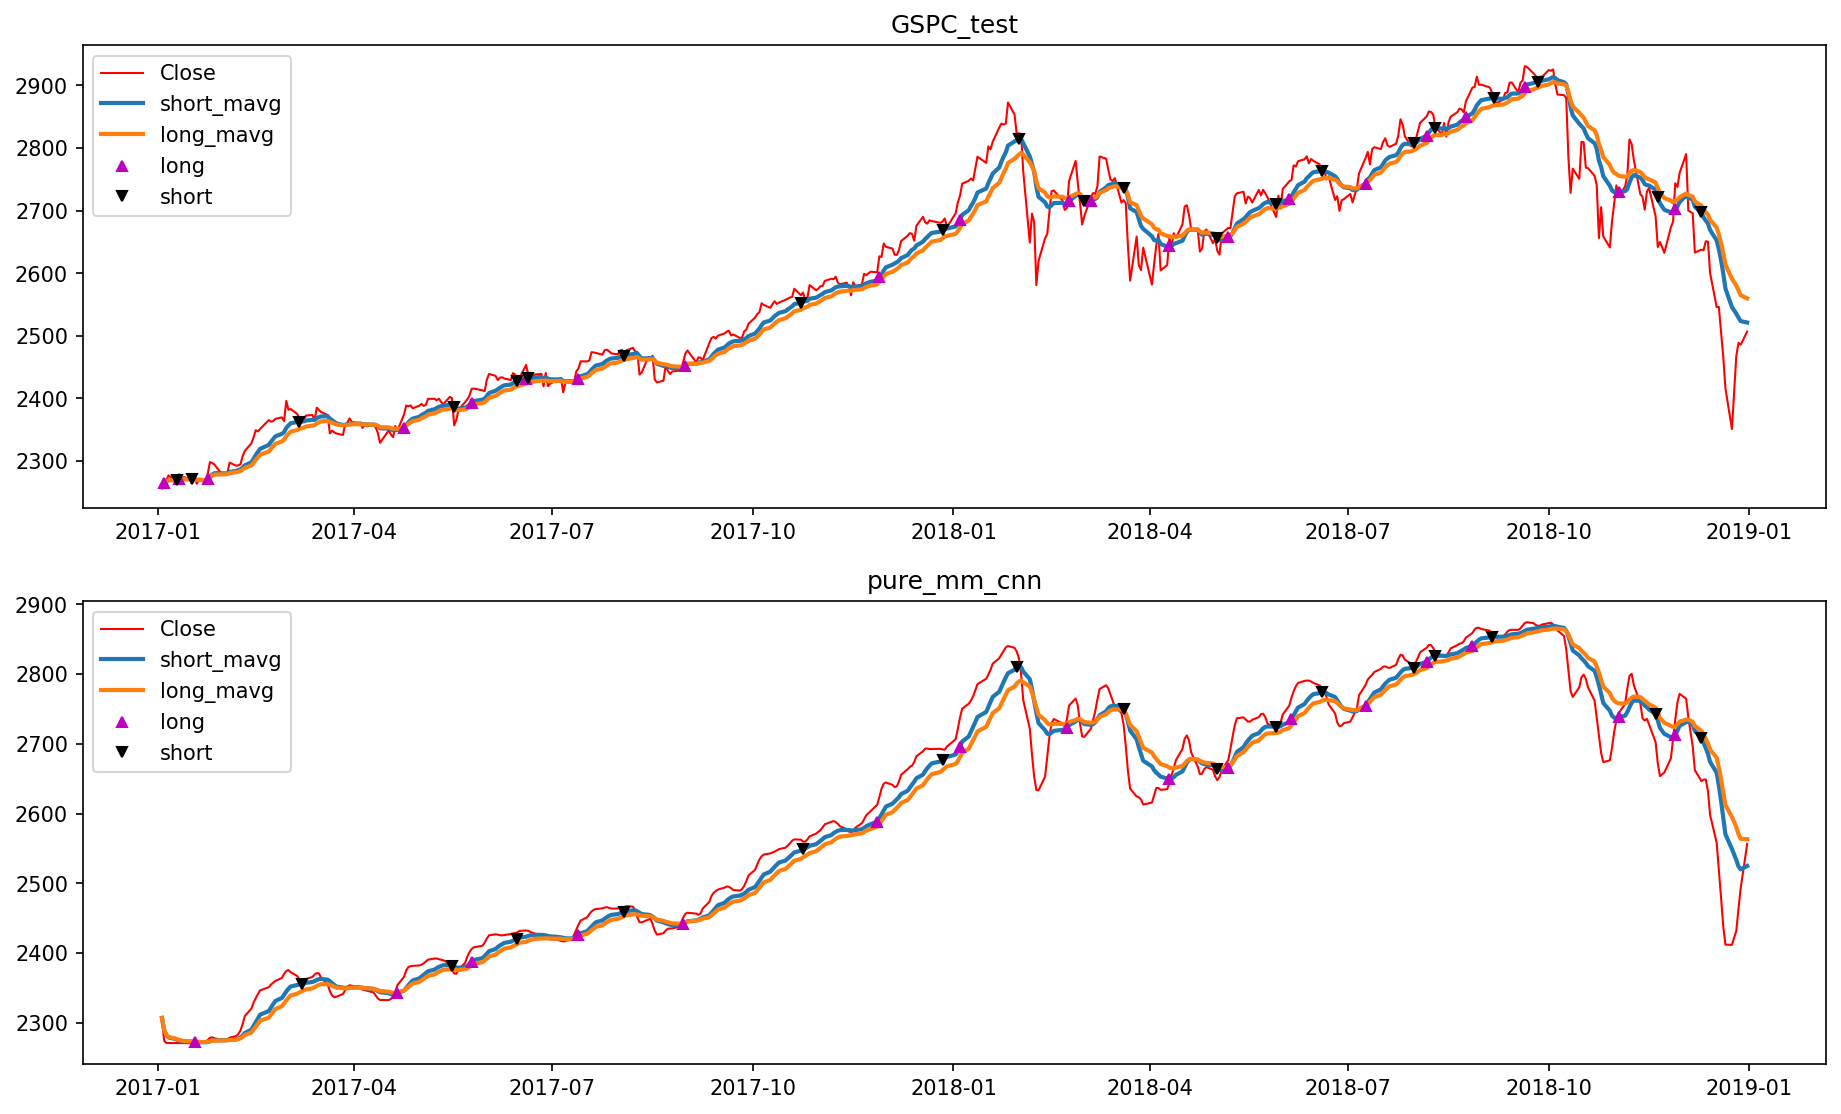

In [43]:
GSPC_test_macd=MACD(GSPC_test_n,short_window = 14,long_window = 22)
pure_mm_cnn_macd=MACD(pure_mm_cnn,short_window = 14,long_window = 22)
#pure_mm_lstm_macd=MACD(pure_mm_lstm,short_window = 14,long_window = 22)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_n['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == 1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == -1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == 1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == -1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [44]:
print('GSPC_test_macd:\n',GSPC_test_macd.positions.value_counts(),'\n')
print('pure_mm_cnn_macd:\n',pure_mm_cnn_macd.positions.value_counts(),'\n')

GSPC_test_macd:
  0.0    459
 1.0     21
-1.0     21
Name: positions, dtype: int64 

pure_mm_cnn_macd:
  0.0    469
 1.0     16
-1.0     16
Name: positions, dtype: int64 



In [45]:
print(GSPC_test[GSPC_test_macd['positions']==1])
print(GSPC_test[pure_mm_cnn_macd['positions']==1])

              Adj Close
Date                   
2017-01-04  2270.750000
2017-01-11  2275.320068
2017-01-24  2280.070068
2017-04-24  2374.149902
2017-05-25  2415.070068
2017-06-19  2453.459961
2017-07-13  2447.830078
2017-08-31  2471.649902
2017-11-28  2627.040039
2018-01-04  2723.989990
2018-02-23  2747.300049
2018-03-05  2720.939941
2018-04-10  2656.870117
2018-05-07  2672.629883
2018-06-04  2746.870117
2018-07-09  2784.169922
2018-08-06  2850.399902
2018-08-24  2874.689941
2018-09-20  2930.750000
2018-11-02  2723.060059
2018-11-28  2743.790039
              Adj Close
Date                   
2017-01-18  2271.889893
2017-04-21  2348.689941
2017-05-25  2415.070068
2017-07-13  2447.830078
2017-08-30  2457.590088
2017-11-27  2601.419922
2018-01-04  2723.989990
2018-02-22  2703.959961
2018-04-10  2656.870117
2018-05-07  2672.629883
2018-06-05  2748.800049
2018-07-09  2784.169922
2018-08-06  2850.399902
2018-08-27  2896.739990
2018-11-02  2723.060059
2018-11-28  2743.790039


In [46]:
print(GSPC_test[GSPC_test_macd['positions']==-1])
print(GSPC_test[pure_mm_cnn_macd['positions']==-1])

              Adj Close
Date                   
2017-01-10  2268.899902
2017-01-17  2267.889893
2017-03-07  2368.389893
2017-05-17  2357.030029
2017-06-15  2432.459961
2017-06-20  2437.030029
2017-08-03  2472.159912
2017-10-23  2564.979980
2017-12-27  2682.620117
2018-01-31  2823.810059
2018-03-02  2691.250000
2018-03-20  2716.939941
2018-05-02  2635.669922
2018-05-29  2689.860107
2018-06-19  2762.590088
2018-07-31  2816.290039
2018-08-10  2833.280029
2018-09-06  2878.050049
2018-09-26  2905.969971
2018-11-20  2641.889893
2018-12-10  2637.719971
              Adj Close
Date                   
2017-03-08  2362.979980
2017-05-16  2400.669922
2017-06-15  2432.459961
2017-08-03  2472.159912
2017-10-24  2569.129883
2017-12-27  2682.620117
2018-01-30  2822.429932
2018-03-20  2716.939941
2018-05-02  2635.669922
2018-05-29  2689.860107
2018-06-19  2762.590088
2018-07-31  2816.290039
2018-08-10  2833.280029
2018-09-05  2888.600098
2018-11-19  2690.729980
2018-12-10  2637.719971


## MA

In [47]:
def MA(dataset,short_window = 10,long_window = 50):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term simple moving averages
    signals['short_mavg'] = dataset['Adj Close'].rolling(window=short_window, min_periods=1).mean()

    # Calculate long term simple moving averages
    signals['long_mavg'] = dataset['Adj Close'].rolling(window=long_window, min_periods=1).mean()

    # Generate signal
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

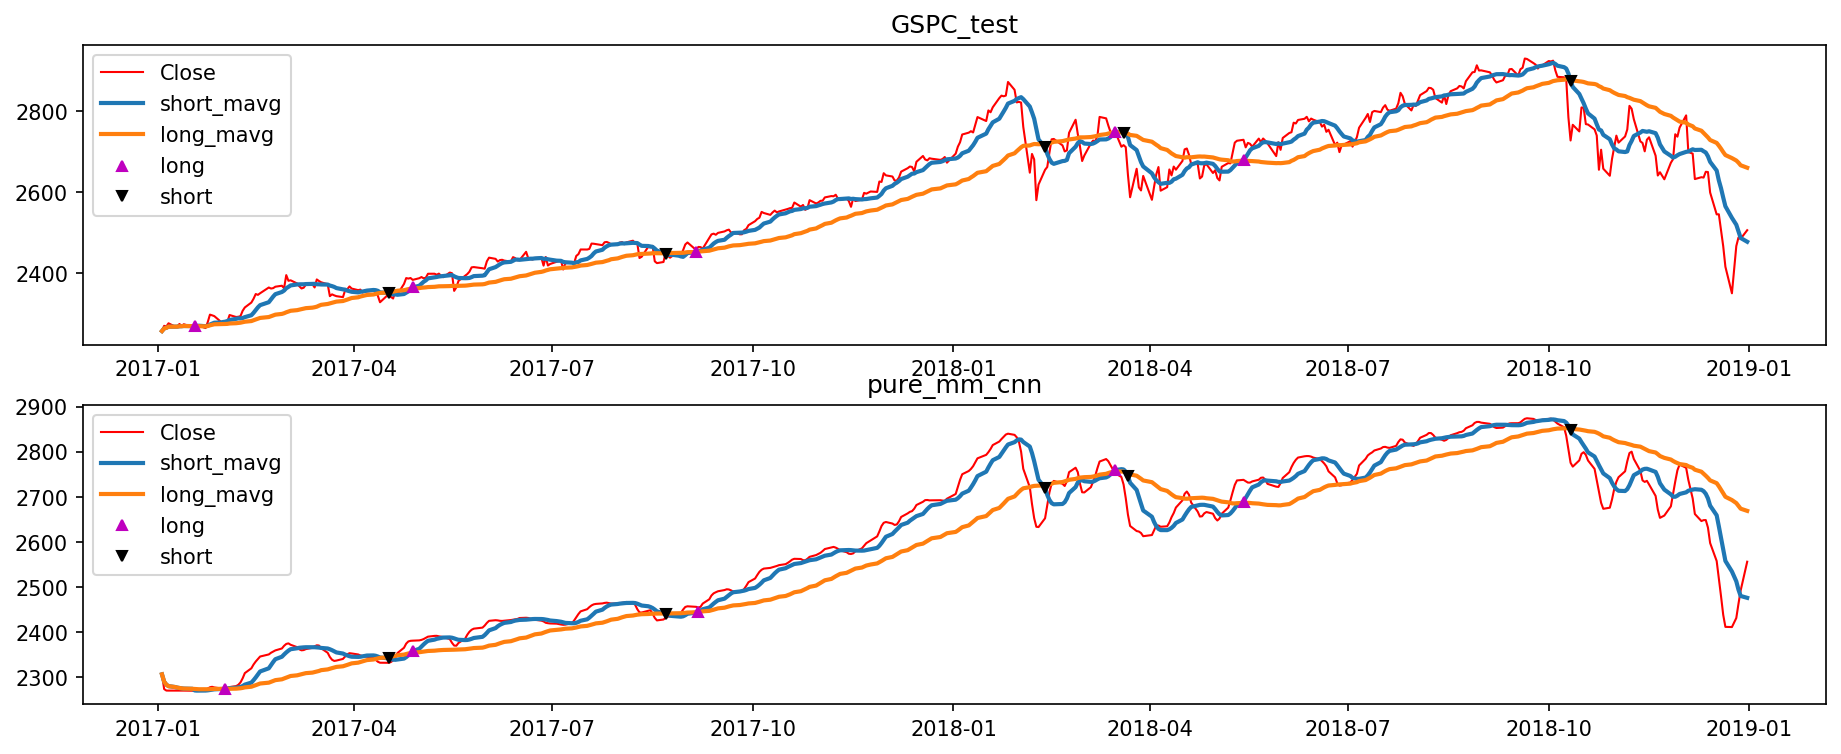

In [48]:
GSPC_test_ma=MA(GSPC_test,short_window = 10,long_window = 50)
pure_mm_cnn_ma=MA(pure_mm_cnn,short_window = 10,long_window = 50)
#pure_mm_lstm_ma=MA(pure_mm_lstm,short_window = 10,long_window = 50)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(3,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == 1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == -1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(3,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == 1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == -1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [49]:
print('GSPC_test_ma:\n',GSPC_test_ma.positions.value_counts(),'\n')
print('pure_mm_cnn_ma:\n',pure_mm_cnn_ma.positions.value_counts(),'\n')

GSPC_test_ma:
  0.0    491
 1.0      5
-1.0      5
Name: positions, dtype: int64 

pure_mm_cnn_ma:
  0.0    491
 1.0      5
-1.0      5
Name: positions, dtype: int64 



In [50]:
print(GSPC_test[GSPC_test_ma['positions']==1])
print(GSPC_test[pure_mm_cnn_ma['positions']==1])

              Adj Close
Date                   
2017-01-18  2271.889893
2017-04-28  2384.199951
2017-09-05  2457.850098
2018-03-16  2752.010010
2018-05-14  2730.129883
              Adj Close
Date                   
2017-02-01  2279.550049
2017-04-28  2384.199951
2017-09-06  2465.540039
2018-03-16  2752.010010
2018-05-14  2730.129883


In [51]:
print(GSPC_test[GSPC_test_ma['positions']==-1])
print(GSPC_test[pure_mm_cnn_ma['positions']==-1])

              Adj Close
Date                   
2017-04-17  2349.010010
2017-08-22  2452.510010
2018-02-12  2656.000000
2018-03-20  2716.939941
2018-10-11  2728.370117
              Adj Close
Date                   
2017-04-17  2349.010010
2017-08-22  2452.510010
2018-02-12  2656.000000
2018-03-22  2643.689941
2018-10-11  2728.370117


## Strategies backtest

In [52]:
def combinesig(dataset,dataset1,dataset2,dataset3):    
    dataset_backtesting=pd.DataFrame()
    dataset_backtesting['Adj Close']=dataset['Adj Close']
    dataset_backtesting['masig']=dataset1['positions']
    dataset_backtesting['macdsig']=dataset2['positions']
    dataset_backtesting['bbsig']=dataset3['signal']
    return dataset_backtesting

In [53]:
GSPC_backtesting=combinesig(GSPC_test,GSPC_test_ma,GSPC_test_macd,GSPC_test_signal)
pure_mm_cnn_backtesting=combinesig(GSPC_test,pure_mm_cnn_ma,pure_mm_cnn_macd,pure_mm_cnn_signal)


In [54]:
def backtest(dataset,asset=1e8, signal=''):
    share_number = 0
    cash = asset
    for i in range(len(dataset)):
        if dataset[signal][i]==1:
            share_number=share_number+cash//(100*dataset['Adj Close'][i])*100
            if cash//(100*dataset['Adj Close'][i])*100>0:
                cash=cash-cash//(100*dataset['Adj Close'][i])*100*dataset['Adj Close'][i]
        elif dataset[signal][i]==-1:
            cash=cash+share_number*dataset['Adj Close'][i]
            share_number=0
    asset_now=cash+share_number*dataset['Adj Close'][i]
    return_value=(asset_now-asset)/asset
    return return_value

In [55]:
mareturn=backtest(GSPC_backtesting,signal='masig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='masig')
print(mareturn)
print(mareturn_cnn)


0.13375734350585938
0.09609055712890625


In [56]:
mareturn=backtest(GSPC_backtesting,signal='macdsig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='macdsig')
#mareturn_lstm=backtest(pure_mm_lstm_backtesting,signal='macdsig')
print(mareturn)
print(mareturn_cnn)
#print(mareturn_lstm)

0.0422089462890625
0.15967922680664062


In [57]:
mareturn=backtest(GSPC_backtesting,signal='bbsig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='bbsig')
print(mareturn)
print(mareturn_cnn)


0.05261858813476562
-0.0657006435546875


# Only emd

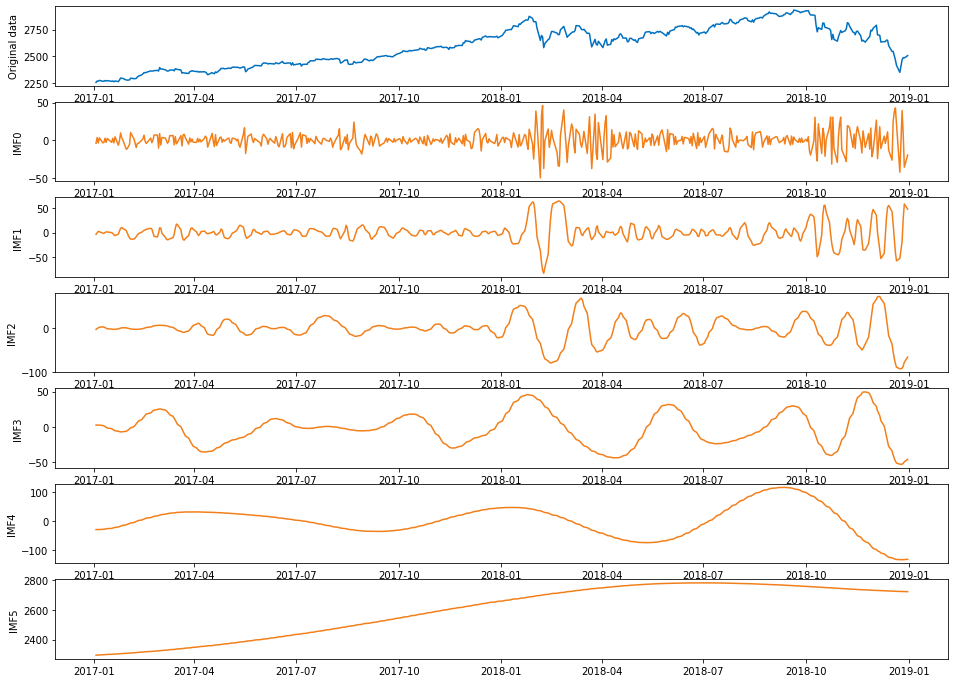

In [83]:
emdre=emd_calculate(GSPC_test)
reedm=reconstruction(emdre)

In [84]:
pure_mm_cnn=pd.DataFrame(reedm.iloc[1,:]).rename(columns={'sum1':'Adj Close'})
pure_mm_cnn

,Adj Close
Date,
2017-01-03,2261.685793
2017-01-04,2267.017768
2017-01-05,2272.543771
2017-01-06,2273.605535
2017-01-09,2272.098741
...,...
2018-12-24,2393.501404
2018-12-26,2428.213685
2018-12-27,2480.400354


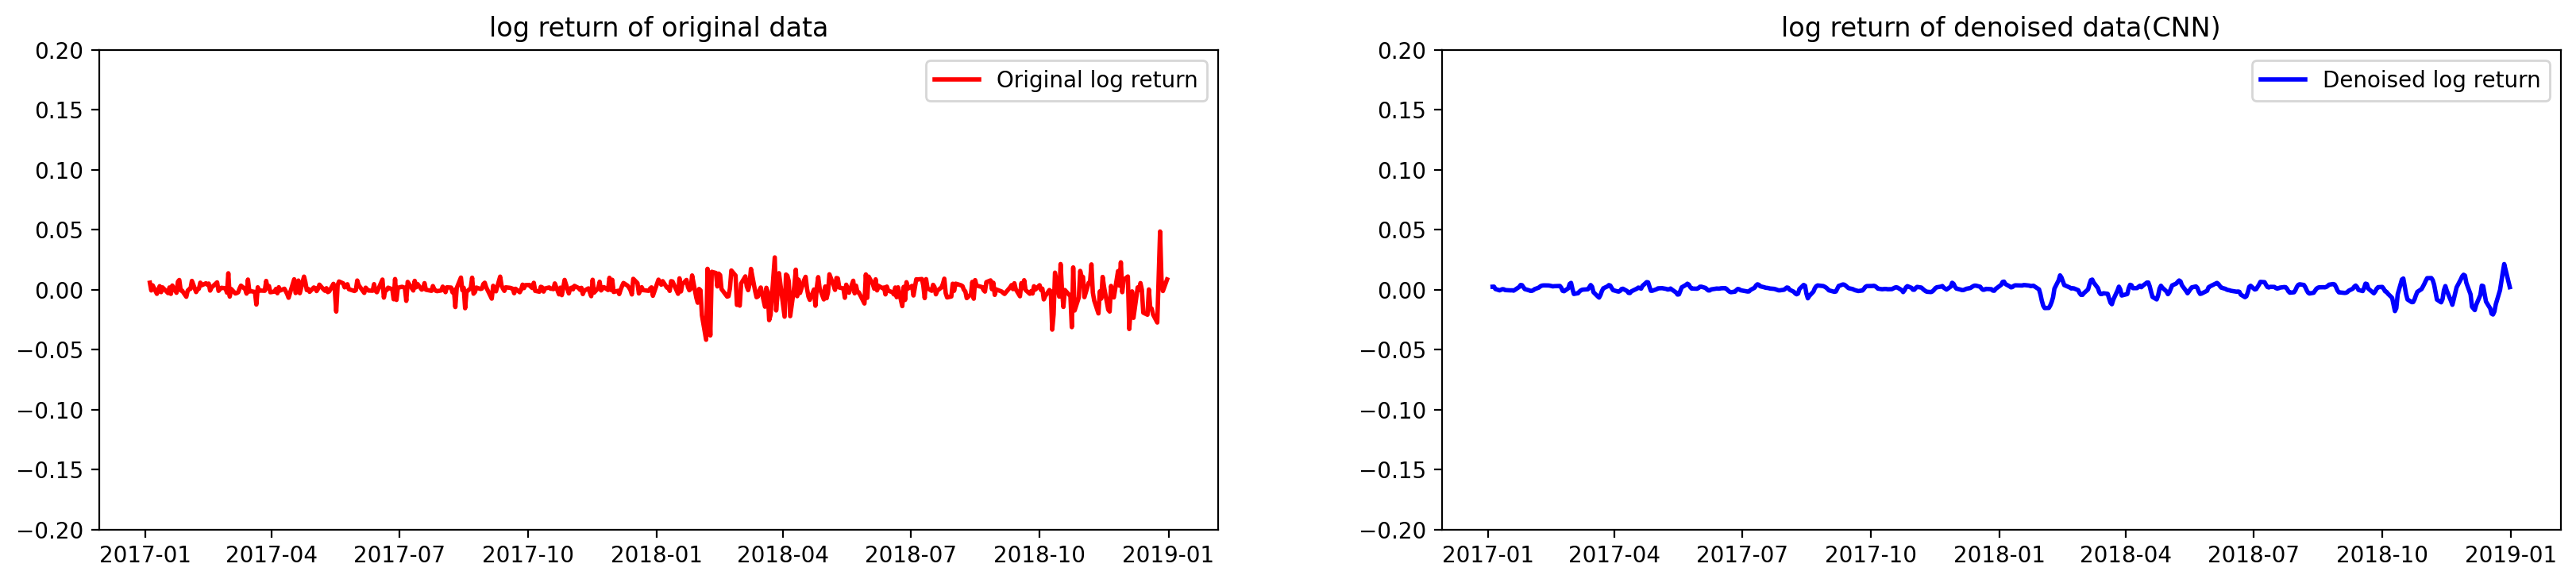

In [68]:
# Log Returns
GSPC_test_n=GSPC_test.copy()
GSPC_test_n['log_ret'] = np.log(GSPC_test.iloc[:,0]).diff()
pure_mm_cnn['log_ret'] = np.log(pure_mm_cnn.iloc[:,0]).diff()


plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,2,1)
plt.plot(GSPC_test_n['log_ret'], 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.2,0.2)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(pure_mm_cnn['log_ret'] , 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.2,0.2)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')


plt.show()

In [69]:
original=pd.DataFrame(GSPC_test['Adj Close'])
recon=pd.DataFrame(pure_mm_cnn['Adj Close'])

In [70]:
def features(dataset):
    ret_dataset=pd.DataFrame(index=dataset.index)
    for i in range(2,52,1):
        window = i
        # Volatility
        ret_dataset[str('SMA'+str(i))] = talib.SMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('EMA'+str(i))] = talib.EMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('STDDEV'+str(i))] = talib.STDDEV(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('Lag'+str(i))] = dataset['Adj Close'].shift(i)
    return ret_dataset

In [71]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import talib
splits=10

1721.426164877124
1762.5094689828593
7077.18783121865
5916.1997755591465
3498.662673626004
1230.0875609168193
273.90029650199705
2620.078336673539
1571.2493416143627
2313.319434817244
The last MSE: 2313.319434817244
The average MSE: 2798.462088478774


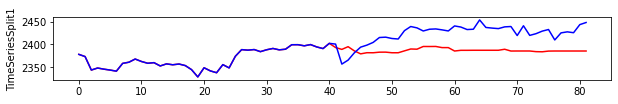

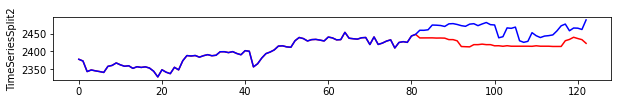

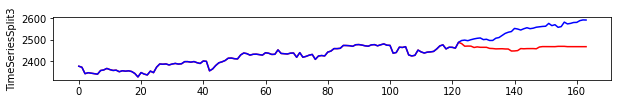

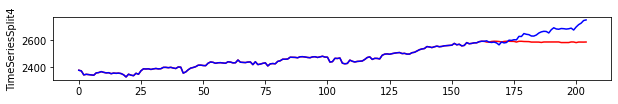

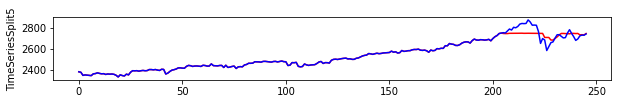

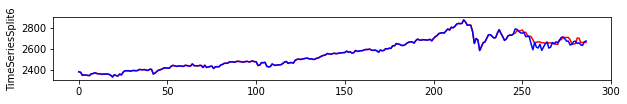

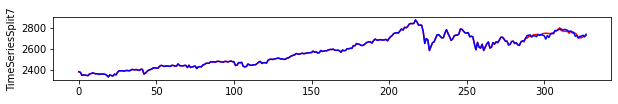

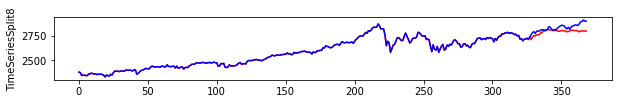

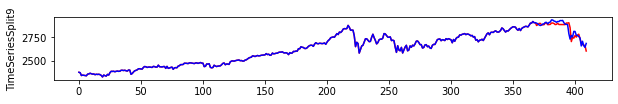

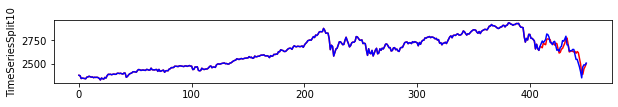

In [72]:
recon_fea=features(recon)
recon_fea=recon_fea.iloc[51:]
original_m=original.iloc[51::]
recon_m=recon.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0

for train_index, test_index in tscv.split(recon_fea):
    model = xgb.XGBRegressor()
    model.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(recon_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    print(msetest)
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

2153.6456390270373
1824.1284457503295
9295.093117856399
5425.715850428837
3484.9116112458996
1631.735811185546
210.3991635499931
2939.401539982819
2227.2013052033217
4746.077826718005
The last MSE: 4746.077826718005
The average MSE: 3393.831031094819


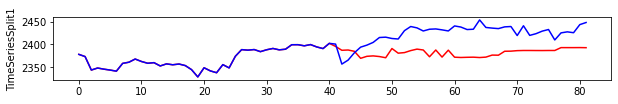

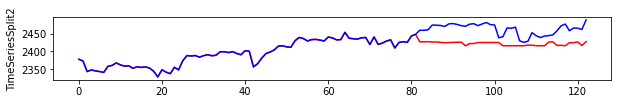

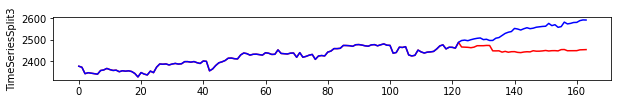

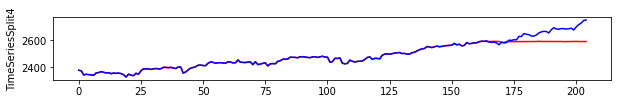

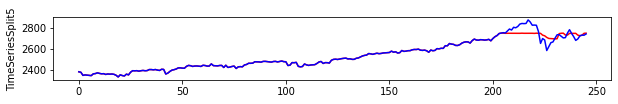

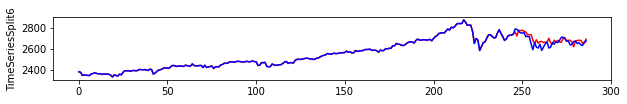

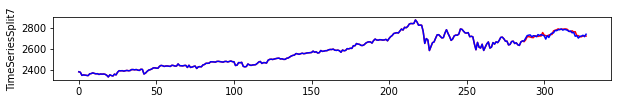

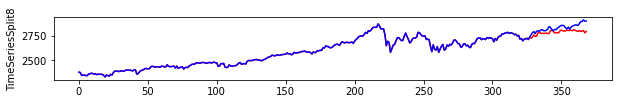

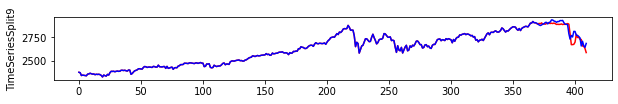

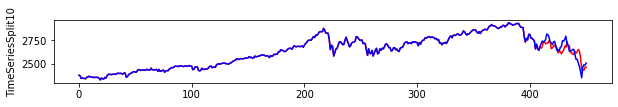

In [73]:
original_fea=features(original)
original_fea=original_fea.iloc[51:]
original_m=original.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(original_fea):
    model = xgb.XGBRegressor()
    model.fit (original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(original_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    msetestav+=msetest
    print(msetest)
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

In [171]:
def svmf1_ori(dataset,dataset2,long_predict=10,percentage=1):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/100):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (0.5*max_t), (0.5*max_t)/100):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [172]:
original_svm_ori,denoised_svm_ori=svmf1_ori(GSPC_test_n,pure_mm_cnn,long_predict=1)

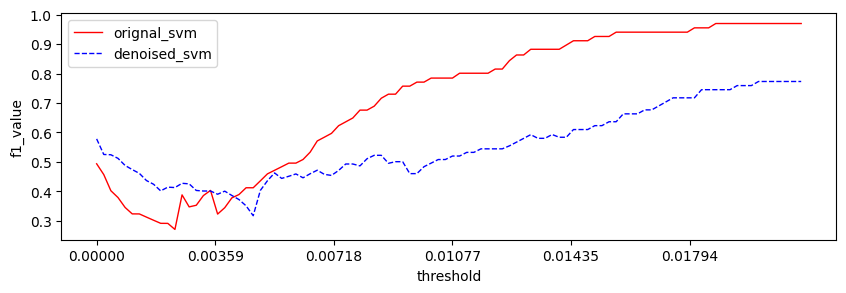

In [224]:
plt.figure(figsize=(10,3),dpi=100)
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/100),original_svm_ori,label='orignal_svm', color='red', linewidth=1.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/100),denoised_svm_ori,label='denoised_svm', color='blue', linewidth=1.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

In [174]:
original=GSPC_test
recon=pure_mm_cnn

In [175]:
def features(dataset):
    ret_dataset=pd.DataFrame(index=dataset.index)
    for i in range(2,52,1):
        window = i
        # Volatility
        ret_dataset[str('SMA'+str(i))] = talib.SMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('EMA'+str(i))] = talib.EMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('STDDEV'+str(i))] = talib.STDDEV(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('Lag'+str(i))] = dataset['Adj Close'].shift(i)
    return ret_dataset

In [176]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import talib
splits=10

In [177]:
recon_fea=features(recon)
recon_fea=recon_fea.iloc[51:]
original_m=original.iloc[51::]
recon_m=recon.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(recon_fea):
    model = xgb.XGBRegressor()
    model.fit(recon_fea.iloc[train_index,:],recon_m.iloc[train_index,:])
    test_predict=model.predict(recon_fea.iloc[test_index,:])
    msetest=mean_squared_error(recon_m.iloc[test_index,:],test_predict)
    msetestav+=msetest
msetestav=msetestav/splits
msetestav

2386.2857208689866

In [178]:
recon_fea=features(recon)
recon_fea=recon_fea.iloc[51:]
original_m=original.iloc[51::]
recon_m=recon.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(recon_fea):
    model = xgb.XGBRegressor()
    model.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(recon_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    msetestav+=msetest
msetestav=msetestav/splits
msetestav

6324.386948050958

In [179]:
original_fea=features(original)
original_fea=original_fea.iloc[51:]
original_m=original.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(original_fea):
    model = xgb.XGBRegressor()
    model.fit(original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(original_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    msetestav+=msetest
msetestav=msetestav/splits
msetestav

7112.400259362197

## Strategies 

## Bollinger band

In [180]:
def bbands(close_prices, window, no_of_stdev):#bollinger  bands, using today's closing price

    rolling_mean = close_prices.rolling(window,min_periods=1).mean()#.shift(1)
    rolling_std = close_prices.rolling(window,min_periods=1).std()#.shift(1)
    

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [181]:
def buy_signal_function(dataset):
    buy_signal=pd.DataFrame(columns=['Price'],index=dataset.index)
    buy_signal['Price']=dataset['Adj Close']
    buy_signal['mean'],buy_signal['upper'],buy_signal['lower']=bbands(dataset['Adj Close'],20,2)
    buy_signal['side'] = np.nan 
    buy_signal['signal'] = np.nan 
    for i in range(0,len(dataset)):
        if (buy_signal.iloc[i,0]<buy_signal.iloc[i,3]):
            buy_signal.iloc[i,4]=1
            if (buy_signal.iloc[i-1,0]>=buy_signal.iloc[i-1,3]):
                buy_signal.iloc[i,5]=1
        elif (buy_signal.iloc[i,0]>buy_signal.iloc[i,2]):
            buy_signal.iloc[i,4]=-1
            if (buy_signal.iloc[i-1,0]<=buy_signal.iloc[i-1,2]):
                buy_signal.iloc[i,5]=-1
    return buy_signal

In [182]:
pure_mm_cnn

,Adj Close,log_ret
Date,,
2018-01-02,2710.009097,NaN
2018-01-03,2714.630694,0.001704
2018-01-04,2721.410446,0.002494
2018-01-05,2729.785277,0.003073
2018-01-08,2739.216770,0.003449
...,...,...
2019-12-24,3231.026993,0.002213
2019-12-26,3233.173992,0.000664
2019-12-27,3231.724024,-0.000449


In [183]:
GSPC_test_signal=buy_signal_function(GSPC_test_n)


pure_mm_cnn_signal=buy_signal_function(pure_mm_cnn)


In [184]:

print('GSPC_test_signal:\n',GSPC_test_signal.signal.value_counts(),'\n')
print('pure_mm_cnn_signal:\n',pure_mm_cnn_signal.signal.value_counts(),'\n')


GSPC_test_signal:
  1.0    12
-1.0    11
Name: signal, dtype: int64 

pure_mm_cnn_signal:
 -1.0    10
 1.0     7
Name: signal, dtype: int64 



In [185]:
print(GSPC_test[GSPC_test_signal.signal == 1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == 1.0])

              Adj Close
Date                   
2018-02-05  2648.939941
2018-02-08  2581.000000
2018-03-22  2643.689941
2018-06-27  2699.629883
2018-10-10  2785.679932
2018-10-24  2656.100098
2018-12-17  2545.939941
2018-12-19  2506.959961
2019-05-13  2811.870117
2019-05-31  2752.060059
2019-08-01  2953.560059
2019-10-01  2940.250000
              Adj Close
Date                   
2018-02-05  2648.939941
2018-03-22  2643.689941
2018-10-09  2880.340088
2018-12-18  2546.159912
2019-05-09  2870.719971
2019-08-01  2953.560059
2019-10-01  2940.250000


In [186]:
print(GSPC_test[GSPC_test_signal.signal == -1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == -1.0])

              Adj Close
Date                   
2018-05-10  2723.070068
2018-06-06  2772.350098
2018-08-27  2896.739990
2018-09-20  2930.750000
2019-03-18  2832.939941
2019-03-21  2854.879883
2019-07-03  2995.820068
2019-09-05  2976.000000
2019-12-12  3168.570068
2019-12-16  3191.449951
2019-12-20  3221.219971
              Adj Close
Date                   
2018-04-18  2708.639893
2018-05-10  2723.070068
2018-06-05  2748.800049
2018-08-06  2850.399902
2018-08-24  2874.689941
2018-09-20  2930.750000
2019-02-04  2724.870117
2019-03-19  2832.570068
2019-09-06  2978.709961
2019-12-11  3141.629883


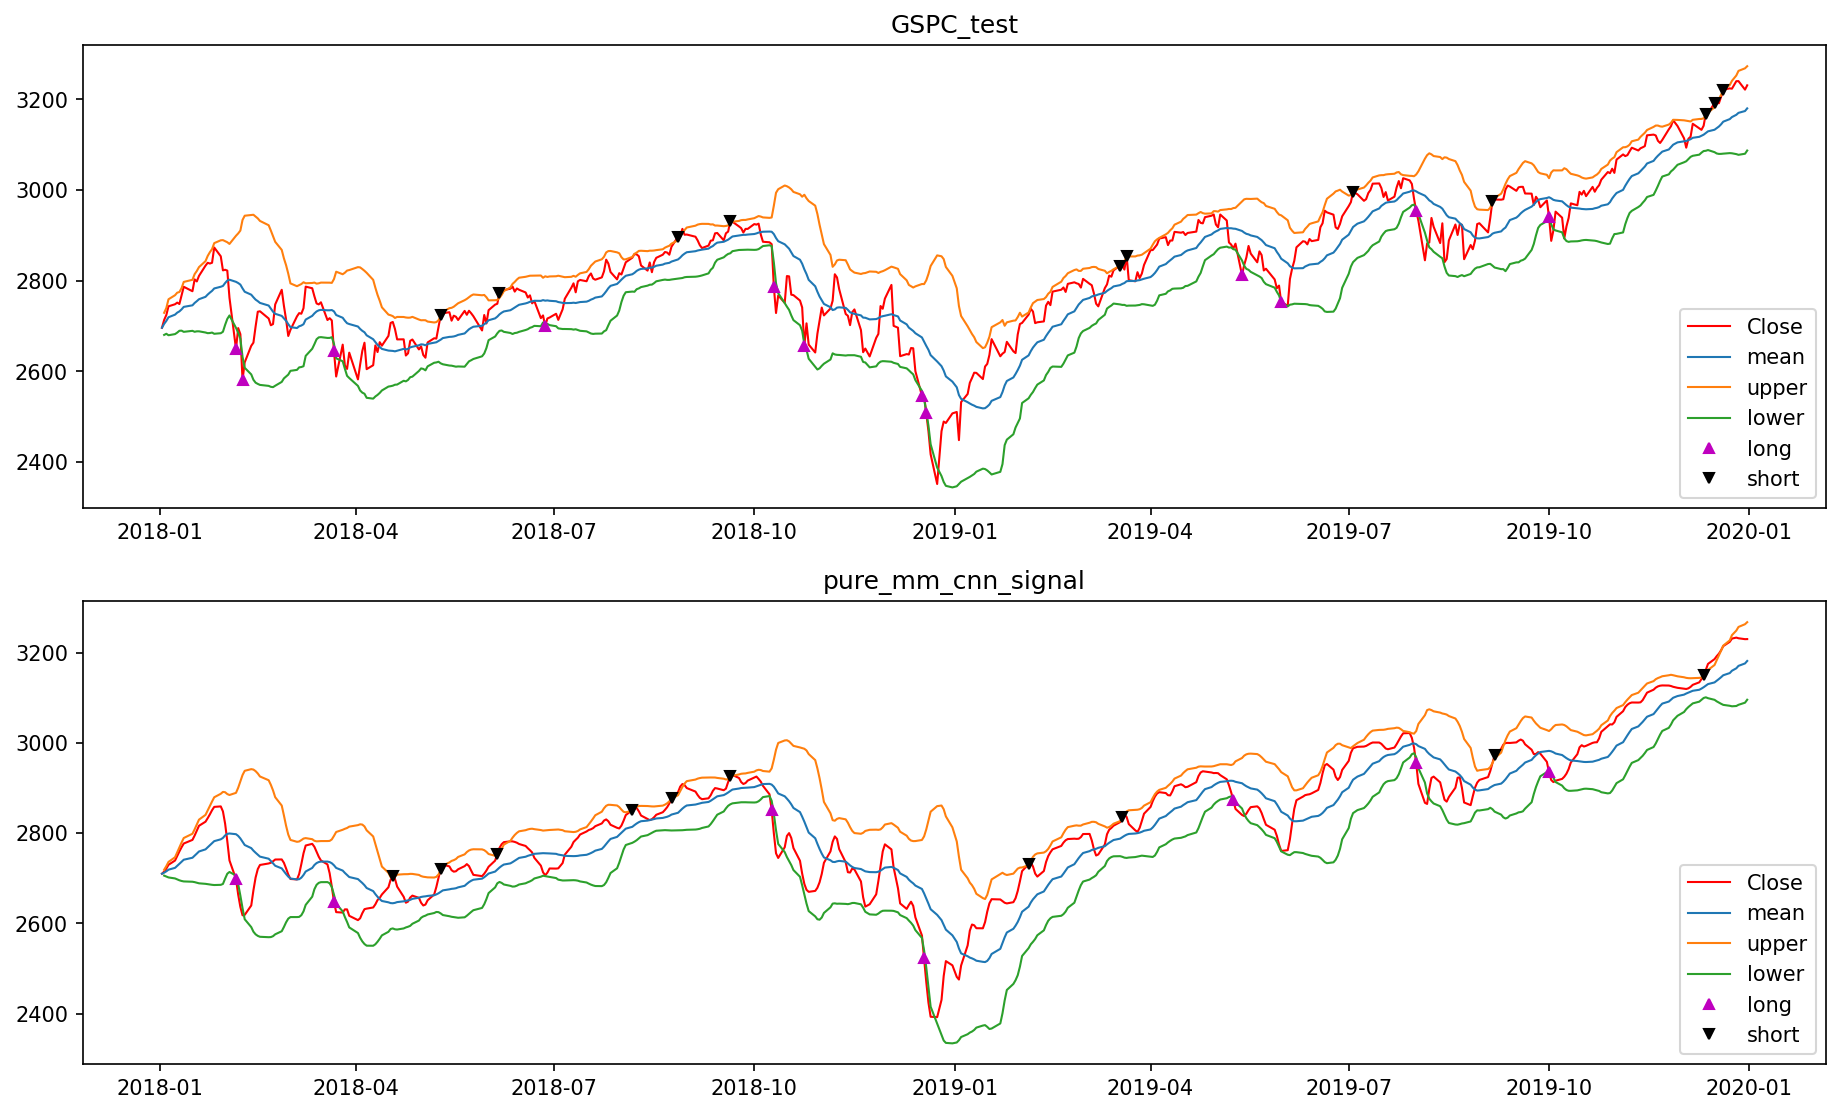

In [187]:
plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_signal['Price'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == 1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == -1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn_signal')
plt.plot(pure_mm_cnn_signal['Price'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == 1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == -1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()    


## MACD

In [188]:
def MACD(dataset,short_window = 12,long_window = 26, signal_window=9):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term moving averages
    signals['short_mavg'] = dataset['Adj Close'].ewm(span=short_window, min_periods=1).mean()

    # Calculate long term moving averages
    signals['long_mavg'] = dataset['Adj Close'].ewm(span=long_window, min_periods=1).mean()
    
    # Calculate DIF 
    signals['DIF'] = signals['short_mavg']-signals['long_mavg']
    
     # Calculate DIF moving averages
    signals['DEA'] = signals['DIF'].ewm(span=signal_window, min_periods=1).mean()

    # Generate signal
    signals['signal'] = np.where(signals['DIF']> signals['DEA'], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

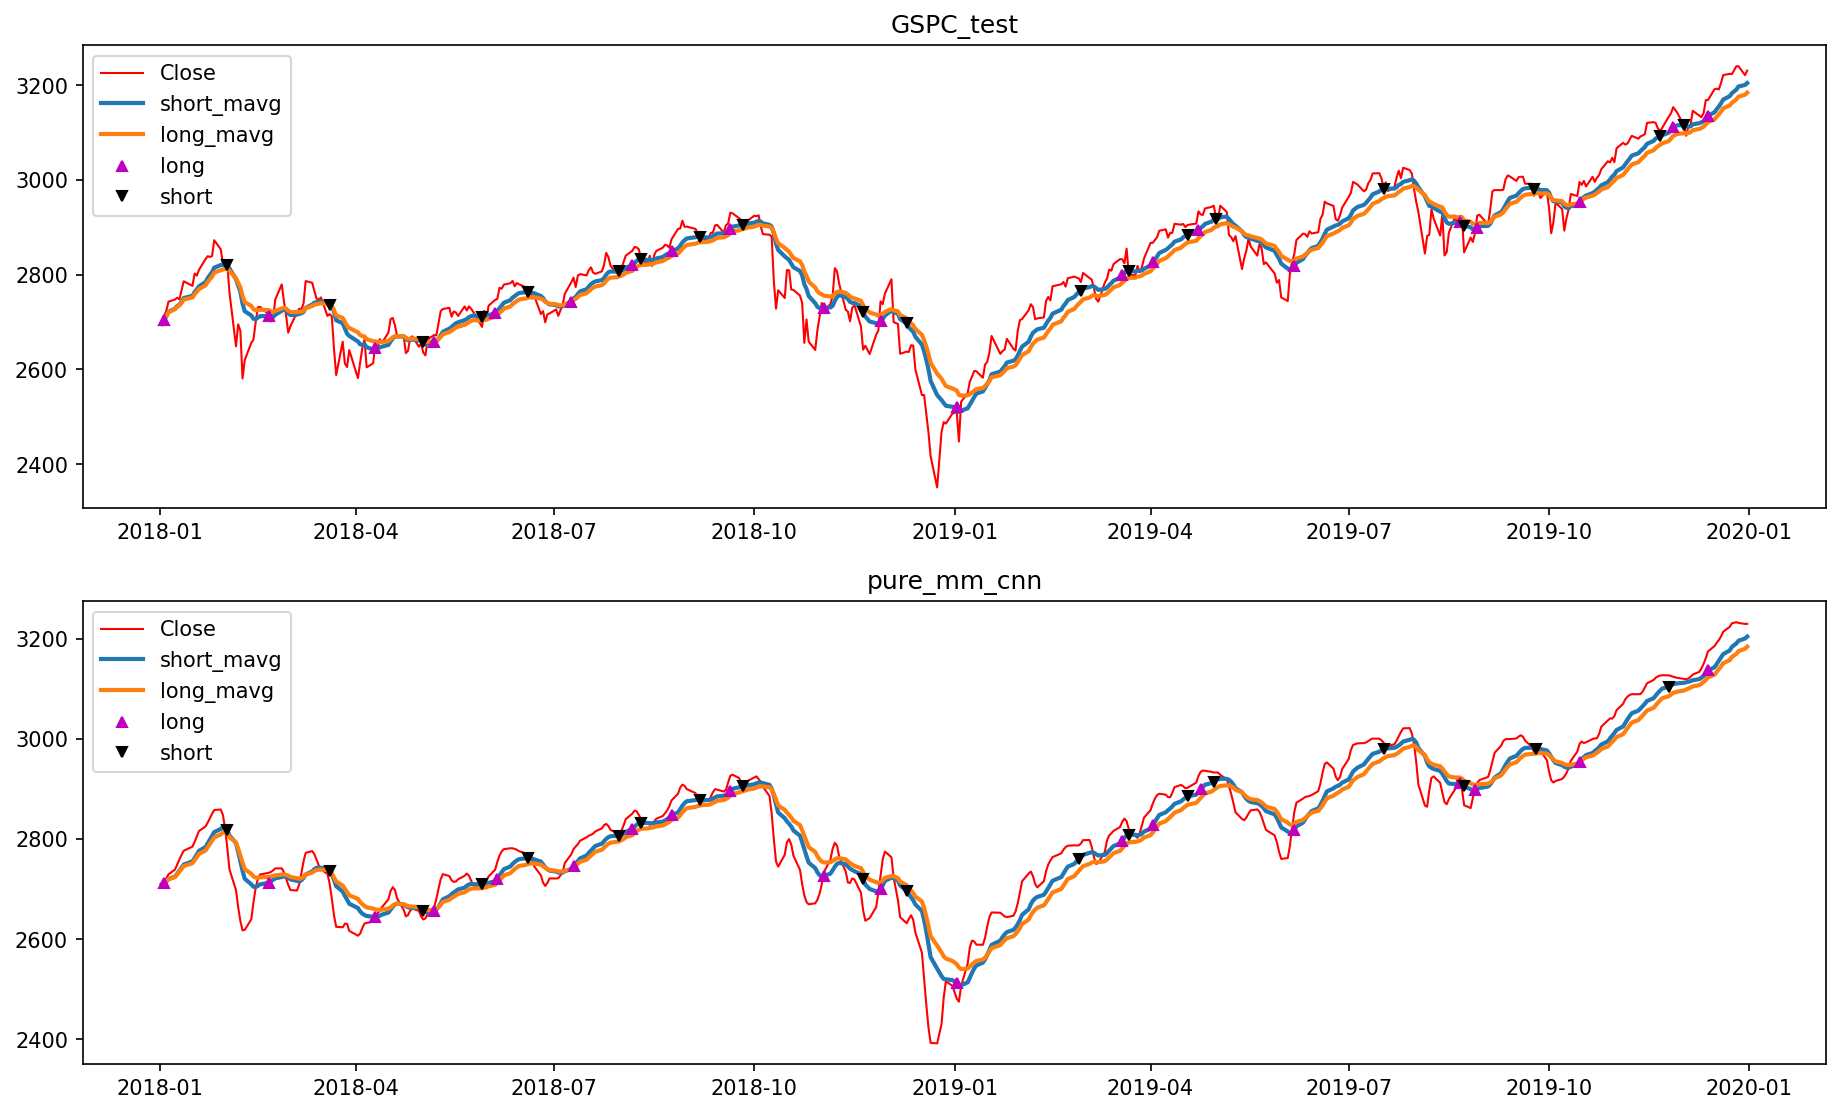

In [189]:
GSPC_test_macd=MACD(GSPC_test_n,short_window = 14,long_window = 22)
pure_mm_cnn_macd=MACD(pure_mm_cnn,short_window = 14,long_window = 22)
#pure_mm_lstm_macd=MACD(pure_mm_lstm,short_window = 14,long_window = 22)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_n['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == 1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == -1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == 1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == -1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [190]:
print('GSPC_test_macd:\n',GSPC_test_macd.positions.value_counts(),'\n')
print('pure_mm_cnn_macd:\n',pure_mm_cnn_macd.positions.value_counts(),'\n')

GSPC_test_macd:
  0.0    461
 1.0     21
-1.0     20
Name: positions, dtype: int64 

pure_mm_cnn_macd:
  0.0    463
 1.0     20
-1.0     19
Name: positions, dtype: int64 



In [191]:
print(GSPC_test[GSPC_test_macd['positions']==1])
print(GSPC_test[pure_mm_cnn_macd['positions']==1])

              Adj Close
Date                   
2018-01-03  2713.060059
2018-02-20  2716.260010
2018-04-10  2656.870117
2018-05-07  2672.629883
2018-06-04  2746.870117
2018-07-09  2784.169922
2018-08-06  2850.399902
2018-08-24  2874.689941
2018-09-20  2930.750000
2018-11-02  2723.060059
2018-11-28  2743.790039
2019-01-02  2510.030029
2019-03-19  2832.570068
2019-04-02  2867.239990
2019-04-23  2933.679932
2019-06-06  2843.489990
2019-08-21  2924.429932
2019-08-29  2924.580078
2019-10-15  2995.679932
2019-11-27  3153.629883
2019-12-13  3168.800049
              Adj Close
Date                   
2018-01-03  2713.060059
2018-02-20  2716.260010
2018-04-10  2656.870117
2018-05-07  2672.629883
2018-06-05  2748.800049
2018-07-10  2793.840088
2018-08-06  2850.399902
2018-08-24  2874.689941
2018-09-20  2930.750000
2018-11-02  2723.060059
2018-11-28  2743.790039
2019-01-02  2510.030029
2019-03-19  2832.570068
2019-04-02  2867.239990
2019-04-24  2927.250000
2019-06-06  2843.489990
2019-08-21  2924

In [192]:
print(GSPC_test[GSPC_test_macd['positions']==-1])
print(GSPC_test[pure_mm_cnn_macd['positions']==-1])

              Adj Close
Date                   
2018-02-01  2821.979980
2018-03-20  2716.939941
2018-05-02  2635.669922
2018-05-29  2689.860107
2018-06-19  2762.590088
2018-07-31  2816.290039
2018-08-10  2833.280029
2018-09-06  2878.050049
2018-09-26  2905.969971
2018-11-20  2641.889893
2018-12-10  2637.719971
2019-02-28  2784.489990
2019-03-22  2800.709961
2019-04-18  2905.030029
2019-05-01  2923.729980
2019-07-17  2984.419922
2019-08-23  2847.110107
2019-09-24  2966.600098
2019-11-21  3103.540039
2019-12-02  3113.870117
              Adj Close
Date                   
2018-02-01  2821.979980
2018-03-20  2716.939941
2018-05-02  2635.669922
2018-05-29  2689.860107
2018-06-19  2762.590088
2018-07-31  2816.290039
2018-08-10  2833.280029
2018-09-06  2878.050049
2018-09-26  2905.969971
2018-11-20  2641.889893
2018-12-10  2637.719971
2019-02-27  2792.379883
2019-03-22  2800.709961
2019-04-18  2905.030029
2019-04-30  2945.830078
2019-07-17  2984.419922
2019-08-23  2847.110107
2019-09-25  2984

## MA

In [193]:
def MA(dataset,short_window = 10,long_window = 50):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term simple moving averages
    signals['short_mavg'] = dataset['Adj Close'].rolling(window=short_window, min_periods=1).mean()

    # Calculate long term simple moving averages
    signals['long_mavg'] = dataset['Adj Close'].rolling(window=long_window, min_periods=1).mean()

    # Generate signal
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

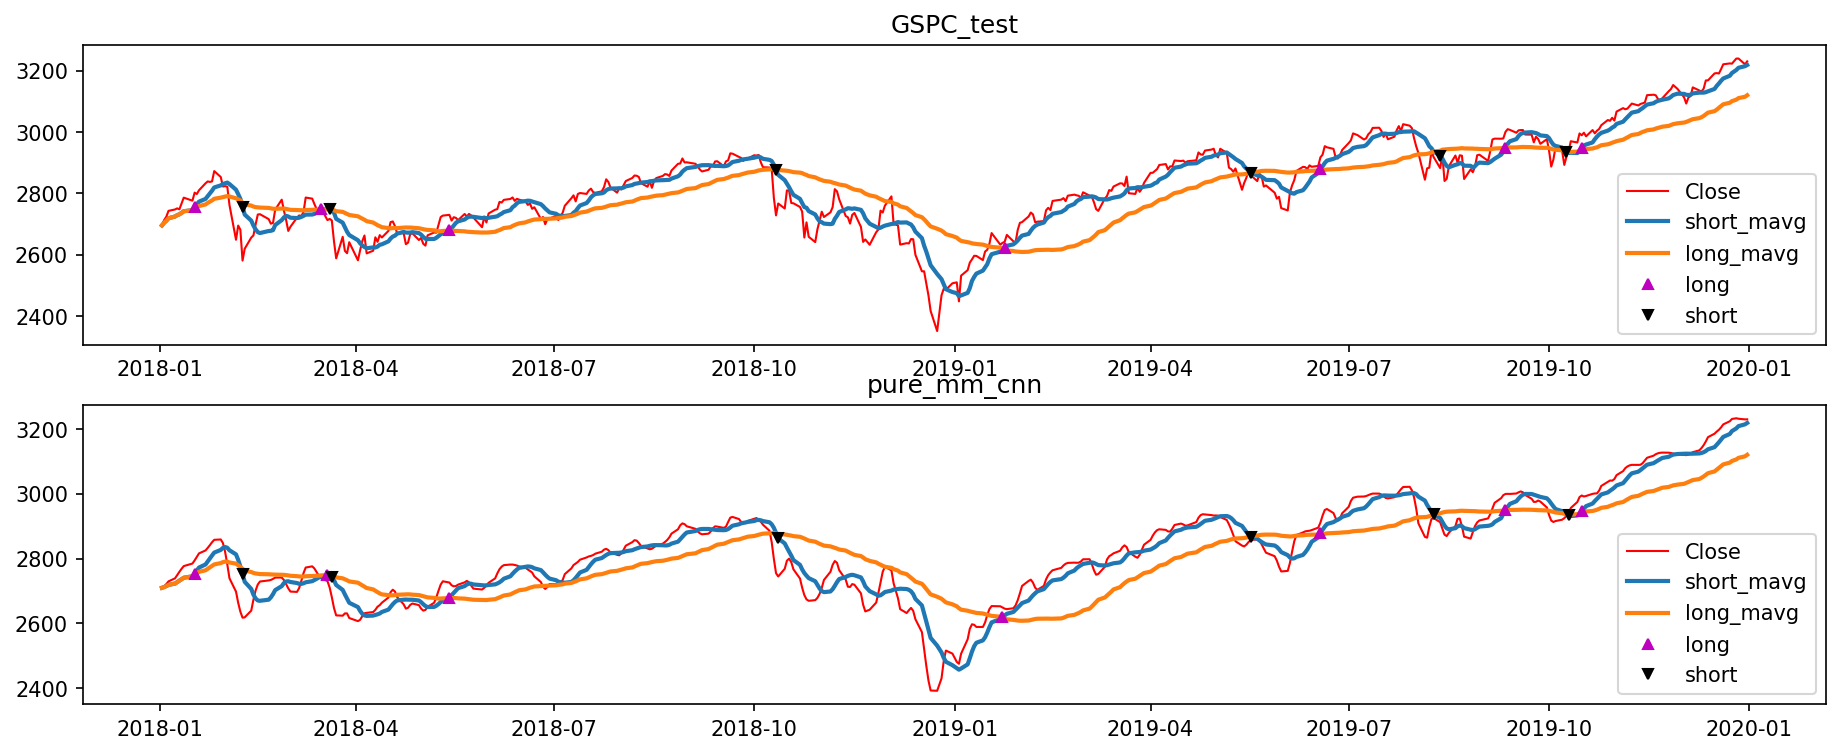

In [194]:
GSPC_test_ma=MA(GSPC_test,short_window = 10,long_window = 50)
pure_mm_cnn_ma=MA(pure_mm_cnn,short_window = 10,long_window = 50)
#pure_mm_lstm_ma=MA(pure_mm_lstm,short_window = 10,long_window = 50)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(3,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == 1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == -1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(3,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == 1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == -1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [195]:
print('GSPC_test_ma:\n',GSPC_test_ma.positions.value_counts(),'\n')
print('pure_mm_cnn_ma:\n',pure_mm_cnn_ma.positions.value_counts(),'\n')

GSPC_test_ma:
  0.0    489
 1.0      7
-1.0      6
Name: positions, dtype: int64 

pure_mm_cnn_ma:
  0.0    489
 1.0      7
-1.0      6
Name: positions, dtype: int64 



In [196]:
print(GSPC_test[GSPC_test_ma['positions']==1])
print(GSPC_test[pure_mm_cnn_ma['positions']==1])

              Adj Close
Date                   
2018-01-17  2802.560059
2018-03-16  2752.010010
2018-05-14  2730.129883
2019-01-24  2642.330078
2019-06-18  2917.750000
2019-09-11  3000.929932
2019-10-16  2989.689941
              Adj Close
Date                   
2018-01-17  2802.560059
2018-03-19  2712.919922
2018-05-14  2730.129883
2019-01-23  2638.699951
2019-06-18  2917.750000
2019-09-11  3000.929932
2019-10-16  2989.689941


In [197]:
print(GSPC_test[GSPC_test_ma['positions']==-1])
print(GSPC_test[pure_mm_cnn_ma['positions']==-1])

              Adj Close
Date                   
2018-02-08  2581.000000
2018-03-20  2716.939941
2018-10-11  2728.370117
2019-05-17  2859.530029
2019-08-12  2882.699951
2019-10-09  2919.399902
              Adj Close
Date                   
2018-02-08  2581.000000
2018-03-21  2711.929932
2018-10-12  2767.129883
2019-05-17  2859.530029
2019-08-09  2918.649902
2019-10-10  2938.129883


## Strategies backtest

In [198]:
def combinesig(dataset,dataset1,dataset2,dataset3):    
    dataset_backtesting=pd.DataFrame()
    dataset_backtesting['Adj Close']=dataset['Adj Close']
    dataset_backtesting['masig']=dataset1['positions']
    dataset_backtesting['macdsig']=dataset2['positions']
    dataset_backtesting['bbsig']=dataset3['signal']
    return dataset_backtesting

In [199]:
GSPC_backtesting=combinesig(GSPC_test,GSPC_test_ma,GSPC_test_macd,GSPC_test_signal)
pure_mm_cnn_backtesting=combinesig(GSPC_test,pure_mm_cnn_ma,pure_mm_cnn_macd,pure_mm_cnn_signal)


In [200]:
def backtest(dataset,asset=1e8, signal=''):
    share_number = 0
    cash = asset
    for i in range(len(dataset)):
        if dataset[signal][i]==1:
            share_number=share_number+cash//(100*dataset['Adj Close'][i])*100
            if cash//(100*dataset['Adj Close'][i])*100>0:
                cash=cash-cash//(100*dataset['Adj Close'][i])*100*dataset['Adj Close'][i]
        elif dataset[signal][i]==-1:
            cash=cash+share_number*dataset['Adj Close'][i]
            share_number=0
    asset_now=cash+share_number*dataset['Adj Close'][i]
    return_value=(asset_now-asset)/asset
    return return_value

In [201]:
mareturn=backtest(GSPC_backtesting,signal='masig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='masig')
print(mareturn)
print(mareturn_cnn)


0.021363199462890625
0.07015959887695312


In [202]:
mareturn=backtest(GSPC_backtesting,signal='macdsig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='macdsig')
#mareturn_lstm=backtest(pure_mm_lstm_backtesting,signal='macdsig')
print(mareturn)
print(mareturn_cnn)
#print(mareturn_lstm)

0.16428684008789063
0.222901642578125


In [203]:
mareturn=backtest(GSPC_backtesting,signal='bbsig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='bbsig')
print(mareturn)
print(mareturn_cnn)


0.29717732739257813
0.07271238891601563
